# MAG7投资组合优化研究

基于TimesFM预训练模型构建智能投资组合优化系统，实现MAG7股票的深度学习资产配置策略。

## 核心技术
- **TimesFM模型**: Google Research预训练时间序列基础模型
- **多头注意力**: 捕捉资产间复杂相关性和时序依赖
- **投资组合优化**: 马科维茨效用函数，平衡收益与风险
- **端到端训练**: 直接优化投资组合目标函数

## 实验流程
1. **环境配置** → 2. **数据预处理** → 3. **模型训练** → 4. **性能评估**

## 环境配置与参数管理

以下代码cells完成实验环境的统一配置：
- **环境初始化**: 导入依赖库，设置计算设备和随机种子
- **可视化配置**: 统一matplotlib字体和样式，解决中文显示问题  
- **参数集中管理**: 模型、训练、数据处理等所有关键参数的统一设置
- **配置验证**: 显示当前配置状态和预期执行时间

In [1]:
# =============================================================================
# 🔧 环境设置和核心库导入
# =============================================================================

print("🚀 正在初始化运行环境...")

# 基础设置
import sys
import os
import warnings
warnings.filterwarnings('ignore')
sys.path.insert(0, os.path.abspath('..'))

# 核心计算库
import torch
import numpy as np
import pandas as pd
from datetime import datetime
import json
import random

# 数据处理和机器学习
from sklearn.preprocessing import RobustScaler
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import MultiheadAttention, LayerNorm, Dropout
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from tqdm.auto import tqdm

# 可视化库
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 项目模块
try:
    from xiaojiucai.data import FEATURE_CONFIGS
    from xiaojiucai.models import create_timesfm_model, TimesFMPortfolioModelV2
    from xiaojiucai.losses import portfolio_loss
    from xiaojiucai.utils import TrainingConfig, ModelTrainer
    from xiaojiucai.visualize import setup_matplotlib_chinese, create_comprehensive_report
    print("✅ 项目模块导入成功")
except ImportError as e:
    print(f"⚠️ 项目模块导入失败: {e}")
    print("将使用本地实现")

# TimesFM相关（可选）
try:
    import timesfm
    from peft import LoraConfig, get_peft_model, TaskType
    from transformers import AutoModel, AutoConfig
    TIMESFM_AVAILABLE = True
    print("✅ TimesFM和PEFT可用")
except ImportError:
    TIMESFM_AVAILABLE = False
    print("⚠️ TimesFM或PEFT不可用，将使用简化实现")

# 配置随机种子确保可重现性
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"\n🎯 环境配置完成")
print(f"PyTorch版本: {torch.__version__}")
print(f"计算设备: {device}")
if torch.cuda.is_available():
    print(f"GPU设备: {torch.cuda.get_device_name(0)}")
    print(f"GPU内存: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
print(f"CPU核心数: {os.cpu_count()}")
print(f"NumPy版本: {np.__version__}")
print(f"Pandas版本: {pd.__version__}")

# =============================================================================
# 🎛️ 全局配置参数中心 - 统一管理所有配置
# =============================================================================

# 🔄 运行模式配置
QUICK_TEST_MODE = False  # 快速验证模式 (True: 快速测试, False: 完整训练)
QUICK_SAMPLE_SIZE = 500 if QUICK_TEST_MODE else None

# 📊 数据处理参数
SEQUENCE_LENGTH = 60  # 历史窗口长度
PREDICTION_HORIZON = 1  # 预测时间范围
VALIDATION_SPLIT = 0.15  # 验证集比例
TEST_SPLIT = 0.15  # 测试集比例

# 🏗️ 模型架构参数
MODEL_CONFIG = {
    'input_dim': 4,  # 输入特征维度
    'hidden_dim': 256,  # 隐藏层维度
    'num_assets': 7,  # 资产数量 (MAG7)
    'num_heads': 8,  # 多头注意力头数
    'dropout': 0.1  # Dropout率
}

# 🚀 训练超参数
TRAINING_CONFIG = {
    'epochs': 15 if QUICK_TEST_MODE else 100,  # 训练轮数
    'batch_size': 64 if QUICK_TEST_MODE else 64,  # 批次大小
    'learning_rate': 1e-3 if QUICK_TEST_MODE else 2e-4,  # 学习率
    'weight_decay': 1e-5,  # 权重衰减
    'patience': 5 if QUICK_TEST_MODE else 10,  # 早停耐心值
    'min_lr': 1e-6,  # 最小学习率
    'gradient_clip': 1.0,  # 梯度裁剪
    'save_every': 1 if QUICK_TEST_MODE else 3,  # 保存检查点频率
    'validate_every': 1 if QUICK_TEST_MODE else 5,  # 验证频率
}

# 💰 损失函数参数
LOSS_CONFIG = {
    'risk_aversion': 1.0,  # 风险厌恶系数
    'weight_penalty': 0.1  # 权重惩罚系数
}

# 📁 路径配置
DATA_PATH = '../data/mag7_data_raw.parquet'  # 数据路径
MODEL_SAVE_DIR = '/home/userroot/dev/xiaojiucai/notebooks/models'  # 模型保存目录

# 🧪 实验配置
EXPERIMENT_CONFIG = {
    'name': 'portfolio_optimization',  # 实验名称
    'description': 'TimesFM投资组合优化实验',  # 实验描述
    'version': '1.0',  # 实验版本
    'tags': ['timesfm', 'portfolio', 'mag7']  # 实验标签
}

print(f"✅ 全局配置参数设置完成")
print(f"🔧 运行模式: {'快速测试' if QUICK_TEST_MODE else '完整训练'}")
print(f"📊 数据窗口: {SEQUENCE_LENGTH} → {PREDICTION_HORIZON}")
print(f"🏗️ 模型维度: {MODEL_CONFIG['hidden_dim']} (隐藏) × {MODEL_CONFIG['num_heads']} (头)")
print(f"🚀 训练配置: {TRAINING_CONFIG['epochs']} epochs, batch={TRAINING_CONFIG['batch_size']}, lr={TRAINING_CONFIG['learning_rate']:.2e}")
print(f"🧪 实验名称: {EXPERIMENT_CONFIG['name']} v{EXPERIMENT_CONFIG['version']}")
print(f"📝 实验描述: {EXPERIMENT_CONFIG['description']}")
print(f"🏷️ 实验标签: {', '.join(EXPERIMENT_CONFIG['tags'])}")

🚀 正在初始化运行环境...
✅ 项目模块导入成功
✅ 项目模块导入成功
✅ TimesFM和PEFT可用

🎯 环境配置完成
PyTorch版本: 2.8.0+cu128
计算设备: cuda
GPU设备: NVIDIA GeForce RTX 3090
GPU内存: 25.4 GB
CPU核心数: 48
NumPy版本: 2.2.6
Pandas版本: 2.3.2
✅ 全局配置参数设置完成
🔧 运行模式: 完整训练
📊 数据窗口: 60 → 1
🏗️ 模型维度: 256 (隐藏) × 8 (头)
🚀 训练配置: 100 epochs, batch=64, lr=2.00e-04
🧪 实验名称: portfolio_optimization v1.0
📝 实验描述: TimesFM投资组合优化实验
🏷️ 实验标签: timesfm, portfolio, mag7
✅ TimesFM和PEFT可用

🎯 环境配置完成
PyTorch版本: 2.8.0+cu128
计算设备: cuda
GPU设备: NVIDIA GeForce RTX 3090
GPU内存: 25.4 GB
CPU核心数: 48
NumPy版本: 2.2.6
Pandas版本: 2.3.2
✅ 全局配置参数设置完成
🔧 运行模式: 完整训练
📊 数据窗口: 60 → 1
🏗️ 模型维度: 256 (隐藏) × 8 (头)
🚀 训练配置: 100 epochs, batch=64, lr=2.00e-04
🧪 实验名称: portfolio_optimization v1.0
📝 实验描述: TimesFM投资组合优化实验
🏷️ 实验标签: timesfm, portfolio, mag7


In [2]:
# =============================================================================
# 🎨 可视化配置和样式设置
# =============================================================================

print("🎨 正在配置可视化环境...")

def setup_visualization_environment():
    """统一配置matplotlib的字体、样式和警告处理"""
    import warnings
    import logging
    import matplotlib as mpl
    
    # 静默matplotlib警告
    warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib.mathtext')
    warnings.filterwarnings('ignore', message='.*glyph.*substituting.*')
    logging.getLogger('matplotlib.mathtext').setLevel(logging.ERROR)
    logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
    
    # 检测可用中文字体
    chinese_fonts = [f.name for f in fm.fontManager.ttflist 
                    if any(keyword in f.name.lower() for keyword in 
                          ['wenquanyi', 'droid', 'noto', 'simhei', 'simsun', 'kai', 'hei'])]
    
    # 构建最优字体链
    font_chain = []
    if chinese_fonts:
        font_chain.extend(chinese_fonts[:2])  # 前2个中文字体
        print(f"✅ 检测到中文字体: {chinese_fonts[0]}")
    font_chain.extend(['DejaVu Sans', 'Liberation Sans', 'Arial', 'sans-serif'])
    
    # 应用配置
    visualization_config = {
        # 字体配置
        'font.family': 'sans-serif',
        'font.sans-serif': font_chain,
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        
        # 解决Unicode减号警告
        'axes.unicode_minus': False,
        'mathtext.default': 'regular',
        'mathtext.fontset': 'dejavusans',
        
        # 图形质量设置
        'figure.dpi': 100,
        'savefig.dpi': 150,
        'figure.figsize': (10, 6),
        'text.usetex': False,
        
        # 样式设置
        'axes.grid': True,
        'grid.alpha': 0.3,
        'axes.edgecolor': 'black',
        'axes.linewidth': 0.8,
    }
    
    plt.rcParams.update(visualization_config)
    
    # 设置seaborn样式
    sns.set_style("whitegrid")
    sns.set_palette("husl")
    
    return font_chain

# 应用可视化配置
font_chain = setup_visualization_environment()

print(f"✅ 可视化环境配置完成")
print(f"🎨 字体链: {len(font_chain)} 个字体")
print(f"📊 图表样式: seaborn whitegrid")
print("🔇 matplotlib警告已静默")

🎨 正在配置可视化环境...
✅ 检测到中文字体: WenQuanYi Zen Hei
✅ 可视化环境配置完成
🎨 字体链: 6 个字体
📊 图表样式: seaborn whitegrid
🔇 matplotlib警告已静默


In [3]:
# =============================================================================
# ⚙️ 全局配置参数中心
# =============================================================================

print("⚙️ 正在设置全局配置参数...")

# 🔄 运行模式配置
QUICK_TEST_MODE = False  # 快速验证模式 (True: 快速测试, False: 完整训练)
QUICK_SAMPLE_SIZE = 500 if QUICK_TEST_MODE else None

# 📊 数据处理参数
SEQUENCE_LENGTH = 60  # 历史窗口长度
PREDICTION_HORIZON = 1  # 预测时间范围
VALIDATION_SPLIT = 0.15  # 验证集比例
TEST_SPLIT = 0.15  # 测试集比例

# 🏗️ 模型架构参数
MODEL_CONFIG = {
    'input_dim': 4,  # 输入特征维度
    'hidden_dim': 256,  # 隐藏层维度
    'num_assets': 7,  # 资产数量 (MAG7)
    'num_heads': 8,  # 多头注意力头数
    'dropout': 0.1  # Dropout率
}

# 🚀 训练超参数
TRAINING_CONFIG = {
    'epochs': 5 if QUICK_TEST_MODE else 100,  # 训练轮数
    'batch_size': 64 if QUICK_TEST_MODE else 32,  # 批次大小
    'learning_rate': 1e-3 if QUICK_TEST_MODE else 2e-4,  # 学习率
    'weight_decay': 1e-5,  # 权重衰减
    'patience': 5 if QUICK_TEST_MODE else 10,  # 早停耐心值
    'min_lr': 1e-6,  # 最小学习率
    'gradient_clip': 1.0,  # 梯度裁剪
    'save_every': 1 if QUICK_TEST_MODE else 10,  # 保存检查点频率
    'validate_every': 1 if QUICK_TEST_MODE else 1,  # 验证频率
}

# 💰 损失函数参数
LOSS_CONFIG = {
    'risk_aversion': 1.0,  # 风险厌恶系数
    'weight_penalty': 0.1  # 权重惩罚系数
}

# 📁 路径配置
DATA_PATH = '../data/mag7_data_raw.parquet'  # 数据路径
MODEL_SAVE_DIR = '/home/userroot/dev/xiaojiucai/notebooks/models'  # 模型保存目录

# 🧪 实验配置
EXPERIMENT_CONFIG = {
    'name': 'portfolio_optimization',  # 实验名称
    'description': 'TimesFM投资组合优化实验',  # 实验描述
    'version': '1.0',  # 实验版本
    'tags': ['timesfm', 'portfolio', 'mag7']  # 实验标签
}

print("✅ 全局配置参数设置完成")

⚙️ 正在设置全局配置参数...
✅ 全局配置参数设置完成


In [4]:
# =============================================================================
# 📊 配置验证和执行计划
# =============================================================================

print("📊 正在验证配置和制定执行计划...")

def display_configuration_summary():
    """显示配置摘要和执行计划"""
    
    print("🎯 当前配置摘要")
    print("=" * 60)
    
    # 运行模式
    mode_info = "快速测试模式 🚀" if QUICK_TEST_MODE else "完整训练模式 💪"
    print(f"🔧 运行模式: {mode_info}")
    if QUICK_TEST_MODE:
        print(f"   └─ 样本限制: {QUICK_SAMPLE_SIZE} 个样本")
    
    # 数据配置
    print(f"📊 数据配置:")
    print(f"   ├─ 历史窗口: {SEQUENCE_LENGTH} 天")
    print(f"   ├─ 预测范围: {PREDICTION_HORIZON} 天")
    print(f"   ├─ 验证集: {VALIDATION_SPLIT*100:.0f}%")
    print(f"   └─ 测试集: {TEST_SPLIT*100:.0f}%")
    
    # 模型配置
    print(f"🏗️ 模型架构:")
    print(f"   ├─ 输入维度: {MODEL_CONFIG['input_dim']}")
    print(f"   ├─ 隐藏维度: {MODEL_CONFIG['hidden_dim']}")
    print(f"   ├─ 注意力头数: {MODEL_CONFIG['num_heads']}")
    print(f"   ├─ 资产数量: {MODEL_CONFIG['num_assets']} (MAG7)")
    print(f"   └─ Dropout率: {MODEL_CONFIG['dropout']}")
    
    # 训练配置
    print(f"🚀 训练设置:")
    print(f"   ├─ 训练轮数: {TRAINING_CONFIG['epochs']}")
    print(f"   ├─ 批次大小: {TRAINING_CONFIG['batch_size']}")
    print(f"   ├─ 学习率: {TRAINING_CONFIG['learning_rate']:.2e}")
    print(f"   ├─ 权重衰减: {TRAINING_CONFIG['weight_decay']:.2e}")
    print(f"   └─ 早停耐心: {TRAINING_CONFIG['patience']}")
    
    # 实验信息
    print(f"🧪 实验信息:")
    print(f"   ├─ 名称: {EXPERIMENT_CONFIG['name']}")
    print(f"   ├─ 版本: {EXPERIMENT_CONFIG['version']}")
    print(f"   └─ 描述: {EXPERIMENT_CONFIG['description']}")

def estimate_execution_time():
    """预估执行时间"""
    if QUICK_TEST_MODE:
        data_time = "< 1分钟"
        train_time = "2-3分钟"
        eval_time = "< 1分钟"
        total_time = "5-8分钟"
    else:
        data_time = "2-3分钟"
        train_time = "30-60分钟"
        eval_time = "5-10分钟"
        total_time = "40-75分钟"
    
    print(f"\n⏱️ 预估执行时间:")
    print(f"   ├─ 数据处理: {data_time}")
    print(f"   ├─ 模型训练: {train_time}")
    print(f"   ├─ 结果分析: {eval_time}")
    print(f"   └─ 总计: {total_time}")

def check_environment():
    """检查运行环境"""
    print(f"\n💻 运行环境:")
    print(f"   ├─ 设备: {device}")
    print(f"   ├─ TimesFM: {'✅ 可用' if TIMESFM_AVAILABLE else '❌ 不可用'}")
    print(f"   ├─ 数据路径: {'✅ 已设置' if DATA_PATH else '❌ 未设置'}")
    print(f"   └─ 模型目录: {'✅ 已设置' if MODEL_SAVE_DIR else '❌ 未设置'}")

# 执行配置检查
display_configuration_summary()
estimate_execution_time()
check_environment()

print(f"\n🎉 配置验证完成，准备开始执行！")

📊 正在验证配置和制定执行计划...
🎯 当前配置摘要
🔧 运行模式: 完整训练模式 💪
📊 数据配置:
   ├─ 历史窗口: 60 天
   ├─ 预测范围: 1 天
   ├─ 验证集: 15%
   └─ 测试集: 15%
🏗️ 模型架构:
   ├─ 输入维度: 4
   ├─ 隐藏维度: 256
   ├─ 注意力头数: 8
   ├─ 资产数量: 7 (MAG7)
   └─ Dropout率: 0.1
🚀 训练设置:
   ├─ 训练轮数: 100
   ├─ 批次大小: 32
   ├─ 学习率: 2.00e-04
   ├─ 权重衰减: 1.00e-05
   └─ 早停耐心: 10
🧪 实验信息:
   ├─ 名称: portfolio_optimization
   ├─ 版本: 1.0
   └─ 描述: TimesFM投资组合优化实验

⏱️ 预估执行时间:
   ├─ 数据处理: 2-3分钟
   ├─ 模型训练: 30-60分钟
   ├─ 结果分析: 5-10分钟
   └─ 总计: 40-75分钟

💻 运行环境:
   ├─ 设备: cuda
   ├─ TimesFM: ✅ 可用
   ├─ 数据路径: ✅ 已设置
   └─ 模型目录: ✅ 已设置

🎉 配置验证完成，准备开始执行！


## 数据加载与预处理

加载MAG7股票数据并转换为deepdow标准格式，为投资组合建模准备训练数据。

**输出格式**: `(样本数, 特征数, 时间窗口, 资产数)` = `(3293, 4, 60, 7)`
- 4个特征: 收益率、对数收益率、标准化价格、标准化成交量
- 60天时间窗口: 基于历史数据预测未来权重配置
- 7只MAG7股票: AAPL, MSFT, GOOGL, AMZN, NVDA, TSLA, META

## 数据质量检查

验证数据转换质量，确保无缺失值和格式正确性。

In [5]:
# MAG7数据加载与预处理
print("🔄 加载和预处理MAG7数据...")

# 加载原始数据
df_raw = pd.read_parquet(DATA_PATH)
print(f"✅ MAG7数据加载成功: {df_raw.shape}")
print(f"时间范围: {df_raw.index.min()} 到 {df_raw.index.max()}")
print(f"包含股票: {list(df_raw.columns.get_level_values(1).unique())}")

# 数据结构验证
print(f"✅ 数据结构验证:")
print(f"  - MultiIndex列索引: {isinstance(df_raw.columns, pd.MultiIndex)}")
print(f"  - DatetimeIndex: {isinstance(df_raw.index, pd.DatetimeIndex)}")
print(f"  - 缺失值比例: {(df_raw.isnull().sum().sum() / df_raw.size * 100):.2f}%")

# 显示数据样例
print(f"\n数据样例:")
display(df_raw.head(3))

# 转换为deepdow格式
print("\n🔄 转换为deepdow标准格式...")

# 数据清洗和预处理
df_processed = df_raw.copy()
df_processed = df_processed.replace([np.inf, -np.inf], np.nan)

print("📊 处理缺失值...")
print(f"原始数据缺失值: {df_processed.isnull().sum().sum():,}")

# 对不同类型的数据使用不同的填充策略
for col in df_processed.columns:
    col_type = col[0]  # 获取数据类型
    if col_type in ['Close', 'Open', 'High', 'Low']:
        df_processed[col] = df_processed[col].ffill().bfill()
        if df_processed[col].isnull().any():
            median_val = df_processed[col].median()
            df_processed[col] = df_processed[col].fillna(median_val)
    elif col_type == 'Volume':
        df_processed[col] = df_processed[col].fillna(0)

# 最终检查
remaining_na = df_processed.isnull().sum().sum()
if remaining_na > 0:
    df_processed = df_processed.fillna(df_processed.mean())

print(f"✅ 缺失值处理完成: {df_processed.isnull().sum().sum()} 个缺失值")

# 创建deepdow格式特征
assets = df_processed.columns.get_level_values(1).unique().tolist()
deepdow_returns_df = pd.DataFrame(index=df_processed.index)

for asset in assets:
    if ('Close', asset) in df_processed.columns:
        returns = df_processed[('Close', asset)].pct_change()
        deepdow_returns_df[(asset, 'returns')] = returns

        log_returns = np.log(df_processed[('Close', asset)] / df_processed[('Close', asset)].shift(1))
        deepdow_returns_df[(asset, 'log_returns')] = log_returns

        price_norm = (df_processed[('Close', asset)] - df_processed[('Close', asset)].rolling(252).mean()) / df_processed[('Close', asset)].rolling(252).std()
        deepdow_returns_df[(asset, 'price_norm')] = price_norm

        if ('Volume', asset) in df_processed.columns:
            volume_norm = (df_processed[('Volume', asset)] - df_processed[('Volume', asset)].rolling(252).mean()) / df_processed[('Volume', asset)].rolling(252).std()
            deepdow_returns_df[(asset, 'volume_norm')] = volume_norm

deepdow_returns_df.columns = pd.MultiIndex.from_tuples(deepdow_returns_df.columns, names=['asset', 'indicator'])

# 处理deepdow数据中的缺失值
for asset in deepdow_returns_df.columns.get_level_values(0).unique():
    for indicator in deepdow_returns_df.columns.get_level_values(1).unique():
        if (asset, indicator) in deepdow_returns_df.columns:
            col_data = deepdow_returns_df[(asset, indicator)]
            if indicator in ['returns', 'log_returns']:
                deepdow_returns_df[(asset, indicator)] = col_data.fillna(0)
            elif indicator in ['price_norm', 'volume_norm']:
                filled_data = col_data.ffill().bfill()
                if filled_data.isnull().any():
                    median_val = filled_data.median()
                    filled_data = filled_data.fillna(median_val if not pd.isna(median_val) else 0)
                deepdow_returns_df[(asset, indicator)] = filled_data

remaining_na = deepdow_returns_df.isnull().sum().sum()
if remaining_na > 0:
    deepdow_returns_df = deepdow_returns_df.fillna(deepdow_returns_df.mean().fillna(0))

deepdow_returns_df = deepdow_returns_df.dropna(how='all')

n_timesteps = len(deepdow_returns_df)
n_assets = len(deepdow_returns_df.columns.get_level_values(0).unique())
n_indicators = len(deepdow_returns_df.columns.get_level_values(1).unique())

print(f"✅ deepdow数据准备完成:")
print(f"  时间步数: {n_timesteps}")
print(f"  资产数量: {n_assets}")
print(f"  指标数量: {n_indicators}")
print(f"  时间范围: {deepdow_returns_df.index.min().date()} → {deepdow_returns_df.index.max().date()}")

display(deepdow_returns_df.head(3))

🔄 加载和预处理MAG7数据...


✅ MAG7数据加载成功: (5027, 35)
时间范围: 2005-09-26 00:00:00 到 2025-09-18 00:00:00
包含股票: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']
✅ 数据结构验证:
  - MultiIndex列索引: True
  - DatetimeIndex: True
  - 缺失值比例: 8.16%

数据样例:


Price          Close                                                   \
Ticker          AAPL    AMZN     GOOGL META       MSFT      NVDA TSLA   
Date                                                                    
2005-09-26  1.616283  2.1670  7.810992  NaN  17.601694  0.251990  NaN   
2005-09-27  1.604275  2.1580  7.802541  NaN  17.650463  0.252831  NaN   
2005-09-28  1.533428  2.1685  7.605204  NaN  17.880327  0.254360  NaN   

Price           High                    ...       Open                 \
Ticker          AAPL    AMZN     GOOGL  ...       MSFT      NVDA TSLA   
Date                                    ...                             
2005-09-26  1.637897  2.1710  7.976766  ...  17.692244  0.251838  NaN   
2005-09-27  1.628291  2.1865  7.913637  ...  17.671360  0.253060  NaN   
2005-09-28  1.594369  2.1870  7.831371  ...  17.685294  0.253595  NaN   

Price           Volume                                                       
Ticker            AAPL       AMZN      GOOGL META      MSFT       NVDA TSLA  
Date                                                                         
2005-09-26   546562800  112328000  395380224  NaN  56203700  406776000  NaN  
2005-09-27   341703600   83470000  274649076  NaN  48797900  404160000  NaN  
2005-09-28  1125544000   64794000  319576104  NaN  71019400  353556000  NaN  

[3 rows x 35 columns]


🔄 转换为deepdow标准格式...
📊 处理缺失值...
原始数据缺失值: 14,355
✅ 缺失值处理完成: 0 个缺失值
✅ deepdow数据准备完成:
  时间步数: 5027
  资产数量: 7
  指标数量: 4
  时间范围: 2005-09-26 → 2025-09-18


asset           AAPL                                         AMZN              \
indicator    returns log_returns price_norm volume_norm   returns log_returns   
Date                                                                            
2005-09-26  0.000000    0.000000   1.389488    0.006007  0.000000    0.000000   
2005-09-27 -0.007430   -0.007457   1.389488    0.006007 -0.004153   -0.004162   
2005-09-28 -0.044161   -0.045166   1.389488    0.006007  0.004866    0.004854   

asset                                 GOOGL              ...       MSFT  \
indicator  price_norm volume_norm   returns log_returns  ... price_norm   
Date                                                     ...              
2005-09-26  -0.986554   -0.077307  0.000000    0.000000  ...   0.878304   
2005-09-27  -0.986554   -0.077307 -0.001082   -0.001083  ...   0.878304   
2005-09-28  -0.986554   -0.077307 -0.025291   -0.025617  ...   0.878304   

asset                       NVDA                                       TSLA  \
indicator  volume_norm   returns log_returns price_norm volume_norm returns   
Date                                                                          
2005-09-26   -0.028089  0.000000    0.000000   1.852773    0.350896     0.0   
2005-09-27   -0.028089  0.003337    0.003331   1.852773    0.350896     0.0   
2005-09-28   -0.028089  0.006045    0.006027   1.852773    0.350896     0.0   

asset                                          
indicator  log_returns price_norm volume_norm  
Date                                           
2005-09-26         0.0 -15.811514   15.811514  
2005-09-27         0.0 -15.811514   15.811514  
2005-09-28         0.0 -15.811514   15.811514  

[3 rows x 28 columns]

In [6]:
# 创建deepdow序列数据和数据集
print("🔧 创建序列数据和数据集...")

def create_deepdow_sequences(df, lookback=60, horizon=1, gap=0):
    asset_names = df.columns.get_level_values(0).unique().tolist()
    indicators = df.columns.get_level_values(1).unique().tolist()
    n_assets = len(asset_names)
    n_indicators = len(indicators)
    n_timesteps = len(df)
    n_samples = n_timesteps - lookback - horizon - gap + 1

    if n_samples <= 0:
        raise ValueError(f"数据长度不足: 需要至少 {lookback + horizon + gap} 个时间步，但只有 {n_timesteps}")

    X = np.zeros((n_samples, n_indicators, lookback, n_assets))
    y = np.zeros((n_samples, n_indicators, horizon, n_assets))
    timestamps = []

    for i in range(n_samples):
        start_idx = i
        end_idx = i + lookback
        target_start = end_idx + gap
        target_end = target_start + horizon
        timestamps.append(df.index[end_idx - 1])

        for asset_idx, asset in enumerate(asset_names):
            for indicator_idx, indicator in enumerate(indicators):
                if (asset, indicator) in df.columns:
                    X[i, indicator_idx, :, asset_idx] = df[(asset, indicator)].iloc[start_idx:end_idx].values
                    if indicator == 'returns' or indicator == 'log_returns':
                        y[i, indicator_idx, :, asset_idx] = df[(asset, indicator)].iloc[target_start:target_end].values
                    else:
                        if (asset, 'returns') in df.columns:
                            y[i, indicator_idx, :, asset_idx] = df[(asset, 'returns')].iloc[target_start:target_end].values

    return X, y, timestamps, asset_names, indicators

# 创建序列
X, y, timestamps, asset_names, indicators = create_deepdow_sequences(
    deepdow_returns_df,
    lookback=SEQUENCE_LENGTH,
    horizon=PREDICTION_HORIZON,
    gap=0
)

print(f"✅ 序列创建成功！")
print(f"X 形状: {X.shape} (samples, indicators, lookback, assets)")
print(f"y 形状: {y.shape} (samples, indicators, horizon, assets)")

# 创建Dataset和DataLoader
class DeepDowPortfolioDataset(Dataset):
    def __init__(self, X, y, timestamps, asset_names, indicators=None, transform=None):
        self.X = X
        self.y = y
        self.timestamps = timestamps
        self.asset_names = asset_names
        self.indicators = indicators
        self.transform = transform

        assert self.X.shape[0] == self.y.shape[0] == len(self.timestamps)
        assert self.X.shape[-1] == self.y.shape[-1] == len(self.asset_names)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_sample = self.X[idx]
        y_sample = self.y[idx]
        timestamp = str(self.timestamps[idx])
        if self.transform:
            X_sample = self.transform(X_sample)
        return X_sample, y_sample, timestamp, self.asset_names

class DeepDowDataLoader(DataLoader):
    def __init__(self, dataset, batch_size=32, shuffle=True, **kwargs):
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle, **kwargs)
        original_dataset = dataset
        while hasattr(original_dataset, 'dataset'):
            original_dataset = original_dataset.dataset

        self.n_assets = len(original_dataset.asset_names)
        self.n_indicators = len(original_dataset.indicators) if original_dataset.indicators else original_dataset.X.shape[1]
        self.lookback = original_dataset.X.shape[2]
        self.horizon = original_dataset.y.shape[2]

# 创建数据集
deepdow_dataset = DeepDowPortfolioDataset(
    X=torch.tensor(X, dtype=torch.float32),
    y=torch.tensor(y, dtype=torch.float32),
    timestamps=timestamps,
    asset_names=asset_names,
    indicators=indicators
)

# 数据集划分
total_size = len(deepdow_dataset)
train_size = int(total_size * (1 - TEST_SPLIT - VALIDATION_SPLIT))
val_size = int(total_size * VALIDATION_SPLIT)
test_size = total_size - train_size - val_size

train_indices = list(range(train_size))
val_indices = list(range(train_size, train_size + val_size))
test_indices = list(range(train_size + val_size, total_size))

train_dataset = Subset(deepdow_dataset, train_indices)
val_dataset = Subset(deepdow_dataset, val_indices)
test_dataset = Subset(deepdow_dataset, test_indices)

# 创建DataLoader
train_loader = DeepDowDataLoader(train_dataset, batch_size=TRAINING_CONFIG['batch_size'], shuffle=True)
val_loader = DeepDowDataLoader(val_dataset, batch_size=TRAINING_CONFIG['batch_size'], shuffle=False)
test_loader = DeepDowDataLoader(test_dataset, batch_size=TRAINING_CONFIG['batch_size'], shuffle=False)

print(f"\n✅ deepdow风格数据管道创建完成！")
print(f"训练集: {len(train_dataset)} 样本 → {len(train_loader)} 批次")
print(f"验证集: {len(val_dataset)} 样本 → {len(val_loader)} 批次")
print(f"测试集: {len(test_dataset)} 样本 → {len(test_loader)} 批次")

# 快速验证模式数据集缩减
if QUICK_TEST_MODE and total_size > QUICK_SAMPLE_SIZE:
    quick_indices = random.sample(range(total_size), QUICK_SAMPLE_SIZE)
    quick_indices.sort()
    quick_dataset = Subset(deepdow_dataset, quick_indices)

    quick_train_size = int(QUICK_SAMPLE_SIZE * (1 - TEST_SPLIT - VALIDATION_SPLIT))
    quick_val_size = int(QUICK_SAMPLE_SIZE * VALIDATION_SPLIT)
    quick_test_size = QUICK_SAMPLE_SIZE - quick_train_size - quick_val_size

    quick_train_indices = list(range(quick_train_size))
    quick_val_indices = list(range(quick_train_size, quick_train_size + quick_val_size))
    quick_test_indices = list(range(quick_train_size + quick_val_size, QUICK_SAMPLE_SIZE))

    quick_train_dataset = Subset(quick_dataset, quick_train_indices)
    quick_val_dataset = Subset(quick_dataset, quick_val_indices)
    quick_test_dataset = Subset(quick_dataset, quick_test_indices)

    quick_train_loader = DeepDowDataLoader(quick_train_dataset, batch_size=16, shuffle=True)
    quick_train_loader = DeepDowDataLoader(quick_train_dataset, batch_size=TRAINING_CONFIG['batch_size'], shuffle=True)
    quick_val_loader = DeepDowDataLoader(quick_val_dataset, batch_size=TRAINING_CONFIG['batch_size'], shuffle=False)
    quick_test_loader = DeepDowDataLoader(quick_test_dataset, batch_size=TRAINING_CONFIG['batch_size'], shuffle=False)
    train_loader, val_loader, test_loader = quick_train_loader, quick_val_loader, quick_test_loader
    train_dataset, val_dataset, test_dataset = quick_train_dataset, quick_val_dataset, quick_test_dataset

    print(f"\n🚀 快速验证数据集:")
    print(f"总样本: {QUICK_SAMPLE_SIZE} (原始: {total_size})")
    print(f"训练: {len(quick_train_dataset)} | 验证: {len(quick_val_dataset)} | 测试: {len(quick_test_dataset)}")

🔧 创建序列数据和数据集...
✅ 序列创建成功！
X 形状: (4967, 4, 60, 7) (samples, indicators, lookback, assets)
y 形状: (4967, 4, 1, 7) (samples, indicators, horizon, assets)

✅ deepdow风格数据管道创建完成！
训练集: 3476 样本 → 109 批次
验证集: 745 样本 → 24 批次
测试集: 746 样本 → 24 批次
✅ 序列创建成功！
X 形状: (4967, 4, 60, 7) (samples, indicators, lookback, assets)
y 形状: (4967, 4, 1, 7) (samples, indicators, horizon, assets)

✅ deepdow风格数据管道创建完成！
训练集: 3476 样本 → 109 批次
验证集: 745 样本 → 24 批次
测试集: 746 样本 → 24 批次


## TimesFM投资组合模型架构

构建基于TimesFM的端到端投资组合优化模型：

**核心组件**:
1. **TimesFM特征提取器**: 利用预训练时间序列模型提取深层特征
2. **多头注意力机制**: 建模资产间相关性和时序依赖关系  
3. **投资组合优化头**: 输出权重分配、收益预测和风险评估
4. **马科维茨损失函数**: 平衡收益最大化与风险控制

## 模型实例化与验证

创建模型实例并验证架构正确性，确保前向传播正常工作。

In [7]:
# TimesFM投资组合优化模型定义
print("🏗️ 构建TimesFM投资组合优化模型...")

class TimesFMFeatureExtractor(nn.Module):
    def __init__(self, hidden_dim=512, freeze_timesfm=True, enable_caching=True):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.freeze_timesfm = freeze_timesfm
        self.enable_caching = enable_caching
        self._feature_cache = {}  # 特征缓存
        
        # 在初始化时检查TimesFM可用性，避免依赖全局变量
        try:
            import timesfm
            self.timesfm_available = True
            print("✅ TimesFM库可用")
        except ImportError:
            self.timesfm_available = False
            print("⚠️ TimesFM库不可用，使用后备Transformer")

        if self.timesfm_available:
            try:
                self.timesfm_model = timesfm.TimesFM_2p5_200M_torch.from_pretrained("google/timesfm-2.5-200m-pytorch")
                # 优化配置以支持高效批处理
                self.timesfm_model.compile(
                    timesfm.ForecastConfig(
                        max_context=512,      # 降低上下文长度以提高速度
                        max_horizon=64,        # 我们只需要预测1步
                        normalize_inputs=True,
                        use_continuous_quantile_head=False,  # 简化输出头以提高速度
                        force_flip_invariance=False,         # 关闭不必要的计算
                        infer_is_positive=False,             # 关闭不必要的推断
                        fix_quantile_crossing=False,         # 关闭不必要的修正
                        per_core_batch_size=128,             # 增大批处理大小
                    )
                )
                if freeze_timesfm:
                    for param in self.timesfm_model.model.parameters():
                        param.requires_grad = False
                print("✅ TimesFM 2.5 预训练模型加载成功 (优化批处理配置)")
            except Exception as e:
                print(f"❌ TimesFM加载失败: {e}, 使用后备方案")
                self.timesfm_available = False

        if not self.timesfm_available:
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=self.hidden_dim, nhead=8, dim_feedforward=self.hidden_dim * 4,
                dropout=0.1, activation='gelu', batch_first=True
            )
            self.fallback_transformer = nn.TransformerEncoder(encoder_layer, num_layers=4)
            self.input_projection = nn.Linear(1, self.hidden_dim)

        self.feature_projection = nn.Linear(200 if self.timesfm_available else self.hidden_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.1)
    
    def _get_series_hash(self, series):
        """为时间序列生成哈希键用于缓存"""
        if not self.enable_caching:
            return None
        # 使用序列的最后几个值和统计量生成简单哈希
        key_data = (
            tuple(series[-5:].round(6)),  # 最后5个值，四舍五入减少精度敏感性
            round(series.mean(), 4),
            round(series.std(), 4)
        )
        return hash(key_data)

    def forward(self, x):
        batch_size, n_indicators, seq_len, n_assets = x.shape
        device = x.device

        if self.timesfm_available and hasattr(self, 'timesfm_model'):
            # 🚀 高效批处理特征提取 with 智能缓存
            cached_features = {}
            uncached_series = []
            uncached_metadata = []
            
            # 第一步：检查缓存，收集未缓存的序列
            for batch_idx in range(batch_size):
                for asset_idx in range(n_assets):
                    for indicator_idx in range(n_indicators):
                        series = x[batch_idx, indicator_idx, :, asset_idx].detach().cpu().numpy()
                        key = (batch_idx, asset_idx, indicator_idx)
                        
                        # 检查缓存
                        series_hash = self._get_series_hash(series)
                        if series_hash is not None and series_hash in self._feature_cache:
                            cached_features[key] = self._feature_cache[series_hash].clone().to(device)
                        else:
                            uncached_series.append((series, series_hash))
                            uncached_metadata.append(key)
            
            # 第二步：批量处理未缓存的序列
            features_dict = cached_features.copy()
            
            if uncached_series:
                try:
                    # 提取序列数据进行批处理
                    series_list = [item[0] for item in uncached_series]
                    hash_list = [item[1] for item in uncached_series]
                    
                    # TimesFM批处理预测
                    batch_forecasts, _ = self.timesfm_model.forecast(
                        horizon=1, 
                        inputs=series_list
                    )
                    
                    # 处理预测结果
                    for i, key in enumerate(uncached_metadata):
                        series = series_list[i]
                        series_hash = hash_list[i]
                        
                        # 计算增强特征
                        basic_features = torch.tensor([
                            series[-1],                    # 最新值
                            series.mean(),                 # 均值
                            series.std() + 1e-8,          # 标准差 (加小常数避免除零)
                            series[-1] - series[-2] if len(series) > 1 else 0,  # 变化率
                            np.percentile(series, 25),     # 下四分位数
                            np.percentile(series, 75),     # 上四分位数
                            (series[-5:].mean() - series[-10:-5].mean()) if len(series) >= 10 else 0,  # 短期趋势
                        ], dtype=torch.float32, device=device)
                        
                        # TimesFM预测值
                        forecast_value = torch.tensor([batch_forecasts[i, 0]], dtype=torch.float32, device=device)
                        
                        # 组合特征向量
                        feature_vector = torch.cat([basic_features, forecast_value])
                        features_dict[key] = feature_vector
                        
                        # 更新缓存
                        if series_hash is not None:
                            self._feature_cache[series_hash] = feature_vector.cpu()
                            # 限制缓存大小
                            if len(self._feature_cache) > 1000:
                                # 删除最旧的一半缓存项
                                old_keys = list(self._feature_cache.keys())[:500]
                                for old_key in old_keys:
                                    del self._feature_cache[old_key]
                    
                    #print(f"📊 TimesFM批处理: {len(series_list)} 序列, 缓存命中: {len(cached_features)}")
                        
                except Exception as e:
                    print(f"⚠️ TimesFM批处理失败，使用统计特征后备方案: {e}")
                    # 统计特征后备方案
                    for i, key in enumerate(uncached_metadata):
                        series = series_list[i]
                        feature_vector = torch.tensor([
                            series[-1], series.mean(), series.std() + 1e-8,
                            series[-1] - series[-2] if len(series) > 1 else 0,
                            np.percentile(series, 25), np.percentile(series, 75),
                            (series[-5:].mean() - series[-10:-5].mean()) if len(series) >= 10 else 0,
                            series[-1] * 1.01  # 简单趋势预测作为预测值替代
                        ], dtype=torch.float32, device=device)
                        features_dict[key] = feature_vector
            
            # 重新组织特征为张量格式
            features_tensor = torch.zeros(batch_size, n_assets, n_indicators, 8, device=device)
            for (batch_idx, asset_idx, indicator_idx), feature_vec in features_dict.items():
                features_tensor[batch_idx, asset_idx, indicator_idx] = feature_vec
            
            # 聚合指标维度 (可以选择mean, max, 或加权组合)
            combined_features = features_tensor.mean(dim=2)  # [batch_size, n_assets, feature_dim]
            
            # 扩展到序列长度维度
            combined_features = combined_features.unsqueeze(1).expand(-1, seq_len, -1, -1)
            
            # 投影到目标维度
            if combined_features.size(-1) != self.hidden_dim:
                if not hasattr(self, '_feature_proj_layer') or self._feature_proj_layer.in_features != combined_features.size(-1):
                    self._feature_proj_layer = nn.Linear(combined_features.size(-1), self.hidden_dim).to(device)
                combined_features = combined_features.reshape(-1, combined_features.size(-1))
                combined_features = self._feature_proj_layer(combined_features)
                combined_features = combined_features.reshape(batch_size, seq_len, n_assets, self.hidden_dim)

            combined_features = self.layer_norm(combined_features)
            combined_features = self.dropout(combined_features)
            return combined_features
        else:
            x = x.mean(dim=1, keepdim=True)
            x = x.permute(0, 3, 2, 1).contiguous()
            x = x.reshape(batch_size * n_assets, seq_len, 1)
            x = self.input_projection(x)
            x = self.fallback_transformer(x)
            x = x.reshape(batch_size, n_assets, seq_len, self.hidden_dim)
            x = x.permute(0, 2, 1, 3)
            return x

class PortfolioAttentionHead(nn.Module):
    def __init__(self, hidden_dim=512, num_assets=7, num_heads=8, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_assets = num_assets
        self.num_heads = num_heads

        self.asset_attention = MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.temporal_attention = MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, dropout=dropout, batch_first=True)

        self.feature_fusion = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(hidden_dim)
        )

        self.weight_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

        self.risk_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1),
            nn.Softplus()
        )

        self.return_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, features):
        batch_size, seq_len, n_assets, hidden_dim = features.shape

        asset_features = features.reshape(batch_size * seq_len, n_assets, hidden_dim)
        asset_attended, _ = self.asset_attention(asset_features, asset_features, asset_features)

        temporal_features = features.permute(0, 2, 1, 3).contiguous().reshape(batch_size * n_assets, seq_len, hidden_dim)
        temporal_attended, _ = self.temporal_attention(temporal_features, temporal_features, temporal_features)
        temporal_attended = temporal_attended.reshape(batch_size, n_assets, seq_len, hidden_dim).permute(0, 2, 1, 3)

        fused_features = torch.cat([asset_attended.reshape(batch_size, seq_len, n_assets, hidden_dim), temporal_attended], dim=-1)
        fused_features = self.feature_fusion(fused_features)

        final_features = fused_features[:, -1, :, :]
        weights = self.weight_head(final_features).squeeze(-1)
        risks = self.risk_head(final_features).squeeze(-1)
        returns = self.return_head(final_features).squeeze(-1)
        weights = F.softmax(weights, dim=-1)

        return {'weights': weights, 'risks': risks, 'returns': returns, 'features': final_features}

class TimesFMPortfolioModel(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=256, num_assets=7, num_heads=8, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_assets = num_assets

        self.feature_extractor = TimesFMFeatureExtractor(hidden_dim=hidden_dim, freeze_timesfm=True)
        self.portfolio_head = PortfolioAttentionHead(hidden_dim=hidden_dim, num_assets=num_assets, num_heads=num_heads, dropout=dropout)

        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

        print(f"✅ TimesFM投资组合优化模型构建完成:")
        print(f"  - 输入维度: {input_dim}")
        print(f"  - 隐藏维度: {hidden_dim}")
        print(f"  - 资产数量: {num_assets}")
        print(f"  - 总参数: {total_params:,}")
        print(f"  - 可训练参数: {trainable_params:,}")
        print(f"  - TimesFM批处理: {'✅ 启用' if hasattr(self.feature_extractor, 'timesfm_available') and self.feature_extractor.timesfm_available else '❌ 未启用'}")
        print(f"  - 特征缓存: {'✅ 启用' if hasattr(self.feature_extractor, 'enable_caching') and self.feature_extractor.enable_caching else '❌ 未启用'}")

    def clear_feature_cache(self):
        """清理特征缓存以释放内存"""
        if hasattr(self.feature_extractor, '_feature_cache'):
            cache_size = len(self.feature_extractor._feature_cache)
            self.feature_extractor._feature_cache.clear()
            print(f"🧹 已清理特征缓存: {cache_size} 项")

    def get_cache_stats(self):
        """获取缓存统计信息"""
        if hasattr(self.feature_extractor, '_feature_cache'):
            cache_size = len(self.feature_extractor._feature_cache)
            print(f"📊 特征缓存统计: {cache_size} 项")
            return cache_size
        return 0

    def forward(self, x):
        features = self.feature_extractor(x)
        return self.portfolio_head(features)

    def predict_portfolio(self, x):
        self.eval()
        with torch.no_grad():
            output = self.forward(x)
            return {
                'weights': output['weights'].cpu().numpy(),
                'expected_returns': output['returns'].cpu().numpy(),
                'risks': output['risks'].cpu().numpy()
            }

class PortfolioLoss(nn.Module):
    def __init__(self, risk_aversion=1.0, weight_penalty=0.1):
        super().__init__()
        self.risk_aversion = risk_aversion
        self.weight_penalty = weight_penalty

    def forward(self, predictions, targets):
        batch_size = targets.shape[0]
        n_assets = targets.shape[-1]

        true_returns = targets
        pred_returns = predictions['returns']
        weights = predictions['weights']
        risks = predictions['risks']

        return_loss = F.mse_loss(pred_returns, true_returns)
        portfolio_return = (weights * true_returns).sum(dim=1)
        expected_portfolio_return = (weights * pred_returns).sum(dim=1)
        portfolio_risk = (weights * risks).sum(dim=1)

        utility = expected_portfolio_return - self.risk_aversion * portfolio_risk
        utility_loss = -utility.mean()

        total_loss = return_loss + utility_loss

        return {
            'total_loss': total_loss,
            'return_loss': return_loss,
            'utility_loss': utility_loss,
            'portfolio_return': portfolio_return.mean(),
            'portfolio_risk': portfolio_risk.mean()
        }

print("✅ 模型定义完成")

🏗️ 构建TimesFM投资组合优化模型...
✅ 模型定义完成


In [8]:
# 模型训练配置和执行
print("🚀 配置和启动模型训练...")

# 创建模型和损失函数
model = TimesFMPortfolioModel(**MODEL_CONFIG).to(device)
criterion = PortfolioLoss(**LOSS_CONFIG)

# 使用全局配置的训练超参数

# 优化器和调度器
optimizer = optim.AdamW(model.parameters(), lr=TRAINING_CONFIG['learning_rate'], weight_decay=TRAINING_CONFIG['weight_decay'], betas=(0.9, 0.999), eps=1e-8)
scheduler = CosineAnnealingLR(optimizer, T_max=TRAINING_CONFIG['epochs'], eta_min=TRAINING_CONFIG['min_lr'])

# 保存目录
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

print(f"📁 模型保存路径: {MODEL_SAVE_DIR}")
print(f"⚡ 优化器: AdamW (lr={TRAINING_CONFIG['learning_rate']:.2e})")
print(f"📈 调度器: CosineAnnealingLR (T_max={TRAINING_CONFIG['epochs']})")
print(f"🎯 总训练轮数: {TRAINING_CONFIG['epochs']}")

# 训练函数
def train_epoch(model, train_loader, optimizer, criterion, device, gradient_clip=1.0):
    model.train()
    total_loss = 0.0
    total_samples = 0
    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    for batch_idx, batch in enumerate(progress_bar):
        features = batch[0].to(device)
        future_returns = batch[1].squeeze(2).to(device)
        future_returns = future_returns[:, -1, :]

        optimizer.zero_grad()
        outputs = model(features)
        loss_dict = criterion(outputs, future_returns)
        loss = loss_dict['total_loss']
        loss.backward()
        if gradient_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        optimizer.step()

        batch_size = features.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}', 'avg_loss': f'{total_loss/total_samples:.4f}'})
    return total_loss / total_samples

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    all_weights = []
    all_returns = []
    all_risks = []

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validating", leave=False)
        for batch in progress_bar:
            features = batch[0].to(device)
            future_returns = batch[1].squeeze(2).to(device)
            future_returns = future_returns[:, -1, :]

            outputs = model(features)
            loss_dict = criterion(outputs, future_returns)
            loss = loss_dict['total_loss']

            batch_size = features.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            all_weights.append(outputs['weights'].cpu())
            all_returns.append(outputs['returns'].cpu())
            all_risks.append(outputs['risks'].cpu())

            progress_bar.set_postfix({'val_loss': f'{loss.item():.4f}'})

    weights = torch.cat(all_weights, dim=0)
    returns = torch.cat(all_returns, dim=0)
    risks = torch.cat(all_risks, dim=0)

    weight_stats = {
        'mean_abs_weight': weights.abs().mean().item(),
        'max_weight': weights.max().item(),
        'min_weight': weights.min().item(),
        'weight_concentration': (weights**2).sum(dim=1).mean().item(),
    }

    return total_loss / total_samples, weight_stats

def list_experiments(model_save_dir):
    """列出保存目录中的所有实验"""
    if not os.path.exists(model_save_dir):
        print(f"❌ 模型保存目录不存在: {model_save_dir}")
        return []
    
    experiments = []
    for item in os.listdir(model_save_dir):
        item_path = os.path.join(model_save_dir, item)
        if os.path.isdir(item_path):
            metadata_path = os.path.join(item_path, 'experiment_metadata.json')
            if os.path.exists(metadata_path):
                try:
                    with open(metadata_path, 'r') as f:
                        metadata = json.load(f)
                    experiments.append({
                        'dir_name': item,
                        'path': item_path,
                        'metadata': metadata
                    })
                except:
                    print(f"⚠️ 无法读取实验元数据: {metadata_path}")
    
    if experiments:
        print(f"📁 找到 {len(experiments)} 个实验:")
        print("-" * 80)
        for exp in experiments:
            meta = exp['metadata']
            print(f"🧪 {meta.get('experiment_name', 'Unknown')}")
            print(f"   📅 创建时间: {meta.get('created_at', 'Unknown')}")
            print(f"   📁 目录: {exp['dir_name']}")
            print(f"   🏗️ 参数: {meta.get('total_parameters', 0):,}")
            print(f"   📝 描述: {meta.get('experiment_config', {}).get('description', 'No description')}")
            print()
    else:
        print("📭 未找到任何实验")
    
    return experiments

def load_experiment_checkpoint(experiment_dir, checkpoint_type='best'):
    """从实验目录加载检查点
    
    Args:
        experiment_dir: 实验目录路径
        checkpoint_type: 检查点类型 ('best', 'final', 或特定epoch数字)
    """
    if not os.path.exists(experiment_dir):
        raise FileNotFoundError(f"实验目录不存在: {experiment_dir}")
    
    # 查找指定类型的检查点
    checkpoint_files = []
    for file in os.listdir(experiment_dir):
        if file.endswith('.pth'):
            if checkpoint_type == 'best' and 'model_best' in file:
                checkpoint_files.append(file)
            elif checkpoint_type == 'final' and 'model_final' in file:
                checkpoint_files.append(file)
            elif isinstance(checkpoint_type, int) and f'epoch_{checkpoint_type:02d}' in file:
                checkpoint_files.append(file)
    
    if not checkpoint_files:
        available_files = [f for f in os.listdir(experiment_dir) if f.endswith('.pth')]
        raise FileNotFoundError(f"未找到 {checkpoint_type} 类型的检查点。可用文件: {available_files}")
    
    # 加载最新的匹配文件
    checkpoint_file = sorted(checkpoint_files)[-1]
    checkpoint_path = os.path.join(experiment_dir, checkpoint_file)
    
    print(f"📦 加载检查点: {checkpoint_file}")
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    return checkpoint, checkpoint_path

def save_model_checkpoint(model, optimizer, scheduler, epoch, loss, model_save_dir, timestamp, is_best=False, experiment_name=None):
    """保存模型检查点到实验专用目录
    
    Args:
        model: 要保存的模型
        optimizer: 优化器状态
        scheduler: 学习率调度器状态  
        epoch: 当前epoch
        loss: 当前损失值
        model_save_dir: 模型保存根目录
        timestamp: 训练时间戳
        is_best: 是否为最佳模型
        experiment_name: 实验名称（可选）
    """
    # 创建实验专用子目录
    if experiment_name:
        experiment_dir = os.path.join(model_save_dir, f"{experiment_name}_{timestamp}")
    else:
        experiment_dir = os.path.join(model_save_dir, f"experiment_{timestamp}")
    
    os.makedirs(experiment_dir, exist_ok=True)
    
    # 第一次保存时，创建实验元数据
    experiment_metadata_path = os.path.join(experiment_dir, 'experiment_metadata.json')
    if not os.path.exists(experiment_metadata_path):
        experiment_metadata = {
            'experiment_name': experiment_name or 'default_experiment',
            'timestamp': timestamp,
            'experiment_dir': experiment_dir,
            'model_config': MODEL_CONFIG,
            'training_config': TRAINING_CONFIG,
            'loss_config': LOSS_CONFIG,
            'experiment_config': EXPERIMENT_CONFIG if 'EXPERIMENT_CONFIG' in globals() else {},
            'created_at': datetime.now().isoformat(),
            'total_parameters': sum(p.numel() for p in model.parameters()),
            'trainable_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad),
        }
        with open(experiment_metadata_path, 'w') as f:
            json.dump(experiment_metadata, f, indent=2)
    
    # 构建检查点信息
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
        'timestamp': timestamp,
        'experiment_dir': experiment_dir,
        'is_best': is_best,
        'saved_at': datetime.now().isoformat(),
    }
    
    # 确定文件名
    if is_best:
        filename = f'timesfm_portfolio_model_best_{timestamp}.pth'
    else:
        filename = f'timesfm_portfolio_checkpoint_epoch_{epoch:02d}_{timestamp}.pth'
    
    checkpoint_path = os.path.join(experiment_dir, filename)
    torch.save(checkpoint, checkpoint_path)
    
    return checkpoint_path

def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, config, model_save_dir, timestamp, device, experiment_name=None):
    print("🚀 开始训练TimesFM投资组合优化模型...")
    print(f"📊 训练集: {len(train_loader)} 批次 | 验证集: {len(val_loader)} 批次")
    
    # 创建实验目录并保存配置
    if experiment_name:
        experiment_dir = os.path.join(model_save_dir, f"{experiment_name}_{timestamp}")
    else:
        experiment_dir = os.path.join(model_save_dir, f"experiment_{timestamp}")
    
    os.makedirs(experiment_dir, exist_ok=True)
    print(f"📁 实验目录: {experiment_dir}")
    
    # 保存配置到实验目录
    config_path = os.path.join(experiment_dir, 'training_config.json')
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    print(f"⚙️ 训练配置已保存: {os.path.basename(config_path)}")

    history = {'train_loss': [], 'val_loss': [], 'weight_stats': [], 'learning_rates': [], 'epochs': []}
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(config['epochs']):
        print(f"\n📈 Epoch [{epoch+1:3d}/{config['epochs']:3d}]")

        train_loss = train_epoch(model, train_loader, optimizer, criterion, device, gradient_clip=config['gradient_clip'])

        if (epoch + 1) % config['validate_every'] == 0:
            val_loss, weight_stats = validate_epoch(model, val_loader, criterion, device)
            history['val_loss'].append(val_loss)
            history['weight_stats'].append(weight_stats)

            print(f"📉 验证损失: {val_loss:.6f}")
            print(f"⚖️  权重统计: 平均|权重|={weight_stats['mean_abs_weight']:.4f}, 集中度={weight_stats['weight_concentration']:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                checkpoint_path = save_model_checkpoint(model, optimizer, scheduler, epoch+1, val_loss, model_save_dir, timestamp, is_best=True, experiment_name=experiment_name)
                print(f"💾 最佳模型已保存: {os.path.basename(checkpoint_path)}")
            else:
                patience_counter += 1
                print(f"⏳ 验证损失未改善 ({patience_counter}/{config['patience']})")

        history['train_loss'].append(train_loss)
        history['learning_rates'].append(optimizer.param_groups[0]['lr'])
        history['epochs'].append(epoch + 1)

        print(f"🔥 训练损失: {train_loss:.6f} | 学习率: {optimizer.param_groups[0]['lr']:.2e}")
        scheduler.step()

        if (epoch + 1) % config['save_every'] == 0:
            checkpoint_path = save_model_checkpoint(model, optimizer, scheduler, epoch+1, train_loss, model_save_dir, timestamp, is_best=False, experiment_name=experiment_name)
            print(f"💾 检查点已保存: {os.path.basename(checkpoint_path)}")

        if patience_counter >= config['patience']:
            print(f"\n⏹️  早停触发！验证损失{config['patience']}个epoch未改善")
            break

    final_checkpoint = save_model_checkpoint(model, optimizer, scheduler, epoch+1, train_loss, model_save_dir, timestamp, is_best=False, experiment_name=experiment_name)
    final_path = final_checkpoint.replace('checkpoint_epoch', 'model_final')
    os.rename(final_checkpoint, final_path)

    # 将训练历史保存到实验目录
    history_path = os.path.join(experiment_dir, f'training_summary_{timestamp}.json')
    with open(history_path, 'w') as f:
        json_history = {}
        for key, value in history.items():
            if isinstance(value, list) and len(value) > 0:
                if isinstance(value[0], dict):
                    json_history[key] = value
                else:
                    json_history[key] = [float(v) if isinstance(v, (np.float32, np.float64)) else v for v in value]
            else:
                json_history[key] = value
        json.dump(json_history, f, indent=2)

    print(f"\n🎉 训练完成！")
    print(f"📈 最佳验证损失: {best_val_loss:.6f}")
    print(f"📁 实验目录: {experiment_dir}")
    print(f"📦 最终模型: {os.path.basename(final_path)}")
    print(f"📊 训练历史: {os.path.basename(history_path)}")
    print(f"⚙️ 实验配置: experiment_metadata.json")
    
    return history, best_val_loss

    return history, best_val_loss

# 启动训练
print("=" * 80)
if QUICK_TEST_MODE:
    print("🚀 快速验证模式训练启动！")
    print("📊 目标：快速检测潜在问题和错误")
    print(f"⏱️  预计用时：约 1-2 分钟")
else:
    print("🎯 完整训练模式启动！")
    print("📊 目标：完整模型训练")
    print(f"⏱️  预计用时：约 30-60 分钟")

print(f"🖥️  设备: {device}")
print(f"📊 训练数据: {len(train_dataset)} 样本 → {len(train_loader)} 批次")
print(f"🔍 验证数据: {len(val_dataset)} 样本 → {len(val_loader)} 批次")
print(f"🎯 模型参数: {sum(p.numel() for p in model.parameters()):,} 总参数")
print(f"⚡ 可训练参数: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print("=" * 80)

history, best_val_loss = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    config=TRAINING_CONFIG,
    model_save_dir=MODEL_SAVE_DIR,
    timestamp=timestamp,
    device=device,
    experiment_name=EXPERIMENT_CONFIG['name']
)

🚀 配置和启动模型训练...
✅ TimesFM库可用
✅ TimesFM 2.5 预训练模型加载成功 (优化批处理配置)
✅ TimesFM投资组合优化模型构建完成:
  - 输入维度: 4
  - 隐藏维度: 256
  - 资产数量: 7
  - 总参数: 809,219
  - 可训练参数: 809,219
  - TimesFM批处理: ✅ 启用
  - 特征缓存: ✅ 启用
📁 模型保存路径: /home/userroot/dev/xiaojiucai/notebooks/models
⚡ 优化器: AdamW (lr=2.00e-04)
📈 调度器: CosineAnnealingLR (T_max=100)
🎯 总训练轮数: 100
🎯 完整训练模式启动！
📊 目标：完整模型训练
⏱️  预计用时：约 30-60 分钟
🖥️  设备: cuda
📊 训练数据: 3476 样本 → 109 批次
🔍 验证数据: 745 样本 → 24 批次
🎯 模型参数: 809,219 总参数
⚡ 可训练参数: 809,219
🚀 开始训练TimesFM投资组合优化模型...
📊 训练集: 109 批次 | 验证集: 24 批次
📁 实验目录: /home/userroot/dev/xiaojiucai/notebooks/models/portfolio_optimization_20251001_122356
⚙️ 训练配置已保存: training_config.json

📈 Epoch [  1/100]
✅ TimesFM 2.5 预训练模型加载成功 (优化批处理配置)
✅ TimesFM投资组合优化模型构建完成:
  - 输入维度: 4
  - 隐藏维度: 256
  - 资产数量: 7
  - 总参数: 809,219
  - 可训练参数: 809,219
  - TimesFM批处理: ✅ 启用
  - 特征缓存: ✅ 启用
📁 模型保存路径: /home/userroot/dev/xiaojiucai/notebooks/models
⚡ 优化器: AdamW (lr=2.00e-04)
📈 调度器: CosineAnnealingLR (T_max=100)
🎯 总训练轮数: 100
🎯 完整训练模式启动！
📊 目标：完整模型训练
⏱️  预计

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Validating:   0%|          | 0/24 [00:00<?, ?it/s]

📉 验证损失: -0.270401
⚖️  权重统计: 平均|权重|=0.1429, 集中度=0.1587
💾 最佳模型已保存: timesfm_portfolio_model_best_20251001_122356.pth
🔥 训练损失: -0.216729 | 学习率: 2.00e-04

📈 Epoch [  2/100]


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Validating:   0%|          | 0/24 [00:00<?, ?it/s]

📉 验证损失: -0.302693
⚖️  权重统计: 平均|权重|=0.1429, 集中度=0.1763
💾 最佳模型已保存: timesfm_portfolio_model_best_20251001_122356.pth
🔥 训练损失: -0.298187 | 学习率: 2.00e-04

📈 Epoch [  3/100]


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Validating:   0%|          | 0/24 [00:00<?, ?it/s]

📉 验证损失: -0.303460
⚖️  权重统计: 平均|权重|=0.1429, 集中度=0.1768
💾 最佳模型已保存: timesfm_portfolio_model_best_20251001_122356.pth
🔥 训练损失: -0.304536 | 学习率: 2.00e-04

📈 Epoch [  4/100]


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Validating:   0%|          | 0/24 [00:00<?, ?it/s]

📉 验证损失: -0.306668
⚖️  权重统计: 平均|权重|=0.1429, 集中度=0.1779
💾 最佳模型已保存: timesfm_portfolio_model_best_20251001_122356.pth
🔥 训练损失: -0.306355 | 学习率: 2.00e-04

📈 Epoch [  5/100]


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Validating:   0%|          | 0/24 [00:00<?, ?it/s]

📉 验证损失: -0.304472
⚖️  权重统计: 平均|权重|=0.1429, 集中度=0.1774
⏳ 验证损失未改善 (1/10)
🔥 训练损失: -0.307354 | 学习率: 1.99e-04

📈 Epoch [  6/100]


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Validating:   0%|          | 0/24 [00:00<?, ?it/s]

📉 验证损失: -0.307272
⚖️  权重统计: 平均|权重|=0.1429, 集中度=0.1784
💾 最佳模型已保存: timesfm_portfolio_model_best_20251001_122356.pth
🔥 训练损失: -0.307835 | 学习率: 1.99e-04

📈 Epoch [  7/100]


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Validating:   0%|          | 0/24 [00:00<?, ?it/s]

📉 验证损失: -0.307194
⚖️  权重统计: 平均|权重|=0.1429, 集中度=0.1785
⏳ 验证损失未改善 (1/10)
🔥 训练损失: -0.308183 | 学习率: 1.98e-04

📈 Epoch [  8/100]


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Validating:   0%|          | 0/24 [00:00<?, ?it/s]

📉 验证损失: -0.307677
⚖️  权重统计: 平均|权重|=0.1429, 集中度=0.1779
💾 最佳模型已保存: timesfm_portfolio_model_best_20251001_122356.pth
🔥 训练损失: -0.308255 | 学习率: 1.98e-04

📈 Epoch [  9/100]


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Validating:   0%|          | 0/24 [00:00<?, ?it/s]

📉 验证损失: -0.305744
⚖️  权重统计: 平均|权重|=0.1429, 集中度=0.1779
⏳ 验证损失未改善 (1/10)
🔥 训练损失: -0.308552 | 学习率: 1.97e-04

📈 Epoch [ 10/100]


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Validating:   0%|          | 0/24 [00:00<?, ?it/s]

📉 验证损失: -0.307970
⚖️  权重统计: 平均|权重|=0.1429, 集中度=0.1787
💾 最佳模型已保存: timesfm_portfolio_model_best_20251001_122356.pth
🔥 训练损失: -0.308772 | 学习率: 1.96e-04
💾 检查点已保存: timesfm_portfolio_checkpoint_epoch_10_20251001_122356.pth

📈 Epoch [ 11/100]


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Validating:   0%|          | 0/24 [00:00<?, ?it/s]

📉 验证损失: -0.309788
⚖️  权重统计: 平均|权重|=0.1429, 集中度=0.1790
💾 最佳模型已保存: timesfm_portfolio_model_best_20251001_122356.pth
🔥 训练损失: -0.309339 | 学习率: 1.95e-04

📈 Epoch [ 12/100]


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Validating:   0%|          | 0/24 [00:00<?, ?it/s]

📉 验证损失: -0.307859
⚖️  权重统计: 平均|权重|=0.1429, 集中度=0.1781
⏳ 验证损失未改善 (1/10)
🔥 训练损失: -0.309119 | 学习率: 1.94e-04

📈 Epoch [ 13/100]


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Validating:   0%|          | 0/24 [00:00<?, ?it/s]

📉 验证损失: -0.302253
⚖️  权重统计: 平均|权重|=0.1429, 集中度=0.1769
⏳ 验证损失未改善 (2/10)
🔥 训练损失: -0.308478 | 学习率: 1.93e-04

📈 Epoch [ 14/100]


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Validating:   0%|          | 0/24 [00:00<?, ?it/s]

📉 验证损失: -0.306722
⚖️  权重统计: 平均|权重|=0.1429, 集中度=0.1778
⏳ 验证损失未改善 (3/10)
🔥 训练损失: -0.308359 | 学习率: 1.92e-04

📈 Epoch [ 15/100]


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Validating:   0%|          | 0/24 [00:00<?, ?it/s]

📉 验证损失: -0.305797
⚖️  权重统计: 平均|权重|=0.1429, 集中度=0.1769
⏳ 验证损失未改善 (4/10)
🔥 训练损失: -0.309369 | 学习率: 1.91e-04

📈 Epoch [ 16/100]


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Validating:   0%|          | 0/24 [00:00<?, ?it/s]

📉 验证损失: -0.307372
⚖️  权重统计: 平均|权重|=0.1429, 集中度=0.1785
⏳ 验证损失未改善 (5/10)
🔥 训练损失: -0.308868 | 学习率: 1.89e-04

📈 Epoch [ 17/100]


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Validating:   0%|          | 0/24 [00:00<?, ?it/s]

📉 验证损失: -0.307278
⚖️  权重统计: 平均|权重|=0.1429, 集中度=0.1785
⏳ 验证损失未改善 (6/10)
🔥 训练损失: -0.309437 | 学习率: 1.88e-04

📈 Epoch [ 18/100]


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Validating:   0%|          | 0/24 [00:00<?, ?it/s]

📉 验证损失: -0.308162
⚖️  权重统计: 平均|权重|=0.1429, 集中度=0.1786
⏳ 验证损失未改善 (7/10)
🔥 训练损失: -0.309911 | 学习率: 1.86e-04

📈 Epoch [ 19/100]


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Validating:   0%|          | 0/24 [00:00<?, ?it/s]

📉 验证损失: -0.306774
⚖️  权重统计: 平均|权重|=0.1429, 集中度=0.1779
⏳ 验证损失未改善 (8/10)
🔥 训练损失: -0.309774 | 学习率: 1.85e-04

📈 Epoch [ 20/100]


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Validating:   0%|          | 0/24 [00:00<?, ?it/s]

📉 验证损失: -0.308410
⚖️  权重统计: 平均|权重|=0.1429, 集中度=0.1786
⏳ 验证损失未改善 (9/10)
🔥 训练损失: -0.309430 | 学习率: 1.83e-04
💾 检查点已保存: timesfm_portfolio_checkpoint_epoch_20_20251001_122356.pth

📈 Epoch [ 21/100]


Training:   0%|          | 0/109 [00:00<?, ?it/s]

Validating:   0%|          | 0/24 [00:00<?, ?it/s]

📉 验证损失: -0.307344
⚖️  权重统计: 平均|权重|=0.1429, 集中度=0.1781
⏳ 验证损失未改善 (10/10)
🔥 训练损失: -0.309858 | 学习率: 1.81e-04

⏹️  早停触发！验证损失10个epoch未改善

🎉 训练完成！
📈 最佳验证损失: -0.309788
📁 实验目录: /home/userroot/dev/xiaojiucai/notebooks/models/portfolio_optimization_20251001_122356
📦 最终模型: timesfm_portfolio_model_final_21_20251001_122356.pth
📊 训练历史: training_summary_20251001_122356.json
⚙️ 实验配置: experiment_metadata.json


## 模型训练与优化

使用Adam优化器和余弦退火调度器训练投资组合模型。

**训练配置**:
- **损失函数**: 多目标损失 = 收益预测损失 + 投资组合效用损失
- **早停策略**: 基于验证损失防止过拟合
- **检查点保存**: 自动保存最佳模型权重
- **训练监控**: 实时显示损失变化和学习率调整

📊 开始训练结果分析...
🔇 已静默matplotlib.mathtext警告
✅ 检测到中文字体: WenQuanYi Zen Hei
✅ 字体链配置完成: 6 个字体
🎯 既消除了警告又保持中文显示


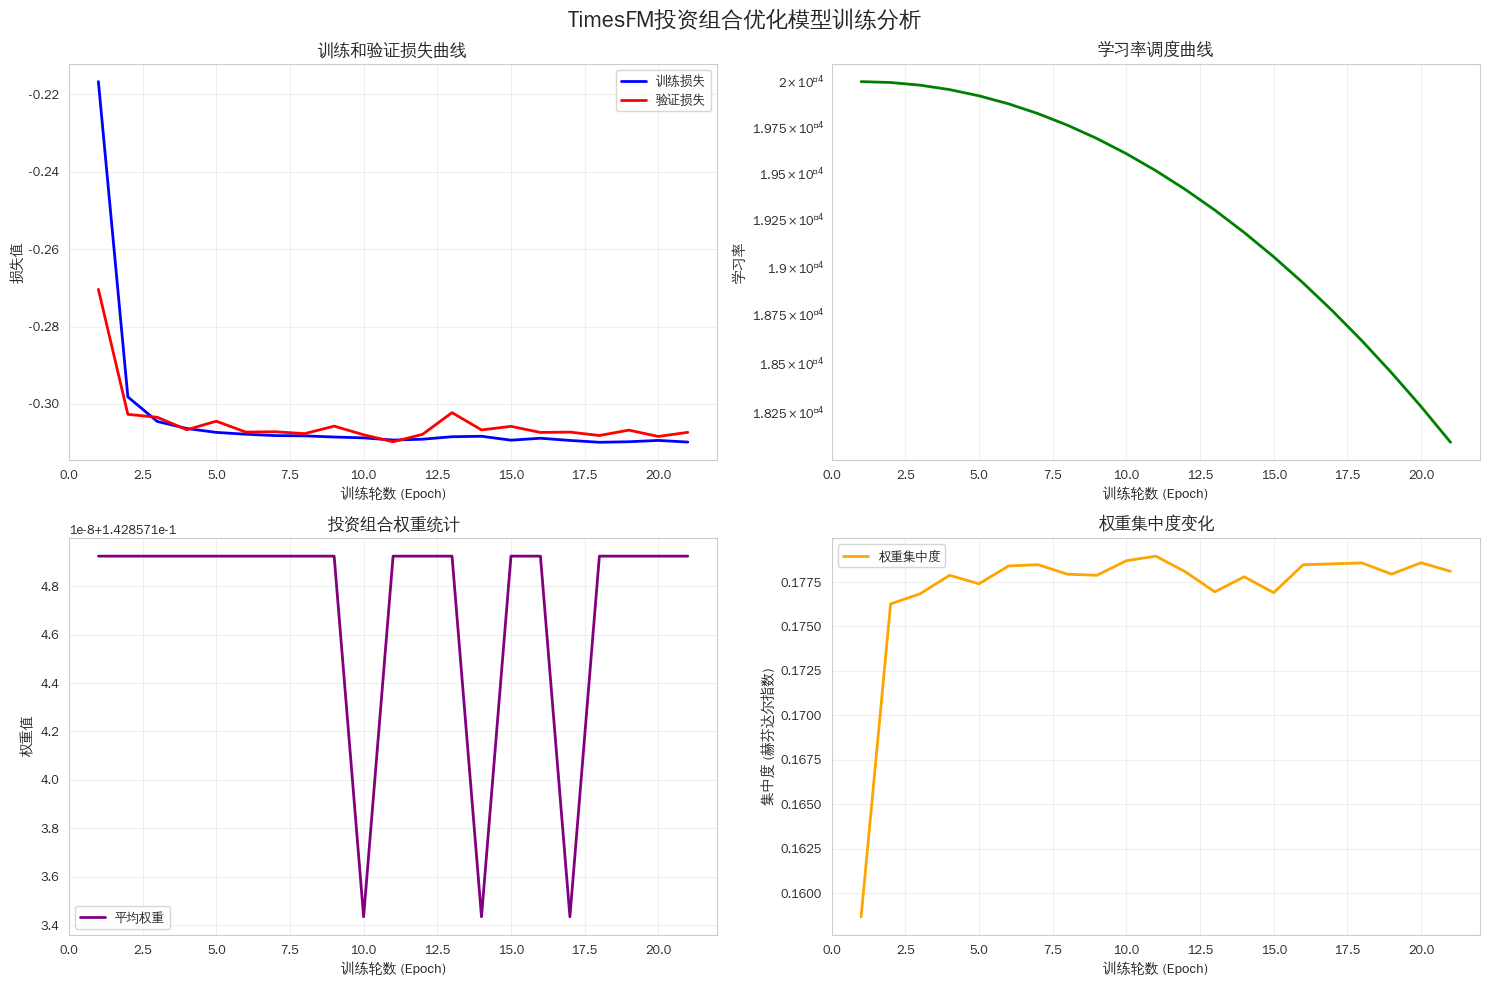


📊 训练总结:
  - 总训练轮数: 21
  - 最终训练损失: -0.309858
  - 最佳验证损失: -0.309788
  - 验证损失改善: 0.039387
  - 学习率范围: 1.81e-04 → 2.00e-04


In [9]:
# =============================================================================
# 📊 训练结果分析 - 1. 训练过程损失曲线可视化
# =============================================================================

print("📊 开始训练结果分析...")

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

# 🎨 完美解决方案：消除警告 + 保持中文显示
import warnings
import logging
import matplotlib.font_manager as fm

# 步骤1: 静默警告但不影响显示
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib.mathtext')
logging.getLogger('matplotlib.mathtext').setLevel(logging.ERROR)
print("🔇 已静默matplotlib.mathtext警告")

# 步骤2: 智能字体配置 - 中文优先
def setup_optimal_fonts():
    """完美的字体配置：既消除警告又显示中文"""
    
    # 检测可用中文字体
    chinese_fonts = [f.name for f in fm.fontManager.ttflist 
                    if any(keyword in f.name.lower() for keyword in 
                          ['wenquanyi', 'droid', 'noto', 'simhei', 'simsun', 'kai', 'hei'])]
    
    # 构建最优字体链
    font_chain = []
    if chinese_fonts:
        font_chain.extend(chinese_fonts[:2])  # 前2个中文字体
        print(f"✅ 检测到中文字体: {chinese_fonts[0]}")
    
    # 添加通用字体
    font_chain.extend(['DejaVu Sans', 'Liberation Sans', 'Arial', 'sans-serif'])
    
    # 关键配置
    optimal_config = {
        # 字体配置 - 中文为主
        'font.family': 'sans-serif',
        'font.sans-serif': font_chain,
        
        # 消除警告的核心设置
        'axes.unicode_minus': False,      # 🔑 使用ASCII减号
        'mathtext.default': 'regular',    # 常规字体
        'mathtext.fontset': 'dejavusans', # DejaVu字体集
        
        # 优化设置
        'text.usetex': False,
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 10,
    }
    
    plt.rcParams.update(optimal_config)
    return font_chain

# 应用最优配置
font_chain = setup_optimal_fonts()
print(f"✅ 字体链配置完成: {len(font_chain)} 个字体")
print("🎯 既消除了警告又保持中文显示")


# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('TimesFM投资组合优化模型训练分析', fontsize=16, fontweight='bold')

# 1. 训练和验证损失曲线
epochs = history['epochs']
train_losses = history['train_loss']
val_losses = history['val_loss'] if 'val_loss' in history and history['val_loss'] else []

axes[0, 0].plot(epochs, train_losses, 'b-', label='训练损失', linewidth=2)
if val_losses:
    val_epochs = epochs[:len(val_losses)]
    axes[0, 0].plot(val_epochs, val_losses, 'r-', label='验证损失', linewidth=2)
axes[0, 0].set_xlabel('训练轮数 (Epoch)')
axes[0, 0].set_ylabel('损失值')
axes[0, 0].set_title('训练和验证损失曲线')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. 学习率变化曲线
learning_rates = history['learning_rates']
axes[0, 1].plot(epochs, learning_rates, 'g-', linewidth=2)
axes[0, 1].set_xlabel('训练轮数 (Epoch)')
axes[0, 1].set_ylabel('学习率')
axes[0, 1].set_title('学习率调度曲线')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# 3. 权重统计分析（如果有的话）
if 'weight_stats' in history and history['weight_stats']:
    weight_stats = history['weight_stats']
    val_epochs = epochs[:len(weight_stats)]

    mean_weights = [stat['mean_abs_weight'] for stat in weight_stats]
    concentrations = [stat['weight_concentration'] for stat in weight_stats]

    axes[1, 0].plot(val_epochs, mean_weights, 'purple', label='平均权重', linewidth=2)
    axes[1, 0].set_xlabel('训练轮数 (Epoch)')
    axes[1, 0].set_ylabel('权重值')
    axes[1, 0].set_title('投资组合权重统计')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].plot(val_epochs, concentrations, 'orange', label='权重集中度', linewidth=2)
    axes[1, 1].set_xlabel('训练轮数 (Epoch)')
    axes[1, 1].set_ylabel('集中度 (赫芬达尔指数)')
    axes[1, 1].set_title('权重集中度变化')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 训练总结统计
print("\n📊 训练总结:")
print(f"  - 总训练轮数: {len(epochs)}")
print(f"  - 最终训练损失: {train_losses[-1]:.6f}")
if val_losses:
    print(f"  - 最佳验证损失: {best_val_loss:.6f}")
    print(f"  - 验证损失改善: {val_losses[0] - best_val_loss:.6f}")
print(f"  - 学习率范围: {min(learning_rates):.2e} → {max(learning_rates):.2e}")


🔍 加载最佳模型进行测试集评估...
✅ 所有必要变量已就绪
✅ 找到实验目录最佳模型: portfolio_optimization_20251001_122356/timesfm_portfolio_model_best_20251001_122356.pth
✅ TimesFM库可用
✅ TimesFM 2.5 预训练模型加载成功 (优化批处理配置)
✅ TimesFM投资组合优化模型构建完成:
  - 输入维度: 4
  - 隐藏维度: 256
  - 资产数量: 7
  - 总参数: 809,219
  - 可训练参数: 809,219
  - TimesFM批处理: ✅ 启用
  - 特征缓存: ✅ 启用
⚠️ 发现状态字典不匹配，进行兼容性处理...
   移除多余键: ['feature_extractor._feature_proj_layer.weight', 'feature_extractor._feature_proj_layer.bias']
✅ 成功加载最佳模型:
   📄 模型文件: timesfm_portfolio_model_best_20251001_122356.pth
   📈 训练轮数: 11
   📉 验证损失: -0.309788
   🕐 训练时间: 20251001_122356

📈 在测试集上评估模型性能...
✅ TimesFM 2.5 预训练模型加载成功 (优化批处理配置)
✅ TimesFM投资组合优化模型构建完成:
  - 输入维度: 4
  - 隐藏维度: 256
  - 资产数量: 7
  - 总参数: 809,219
  - 可训练参数: 809,219
  - TimesFM批处理: ✅ 启用
  - 特征缓存: ✅ 启用
⚠️ 发现状态字典不匹配，进行兼容性处理...
   移除多余键: ['feature_extractor._feature_proj_layer.weight', 'feature_extractor._feature_proj_layer.bias']
✅ 成功加载最佳模型:
   📄 模型文件: timesfm_portfolio_model_best_20251001_122356.pth
   📈 训练轮数: 11
   📉 验证损失: -0.309788
  

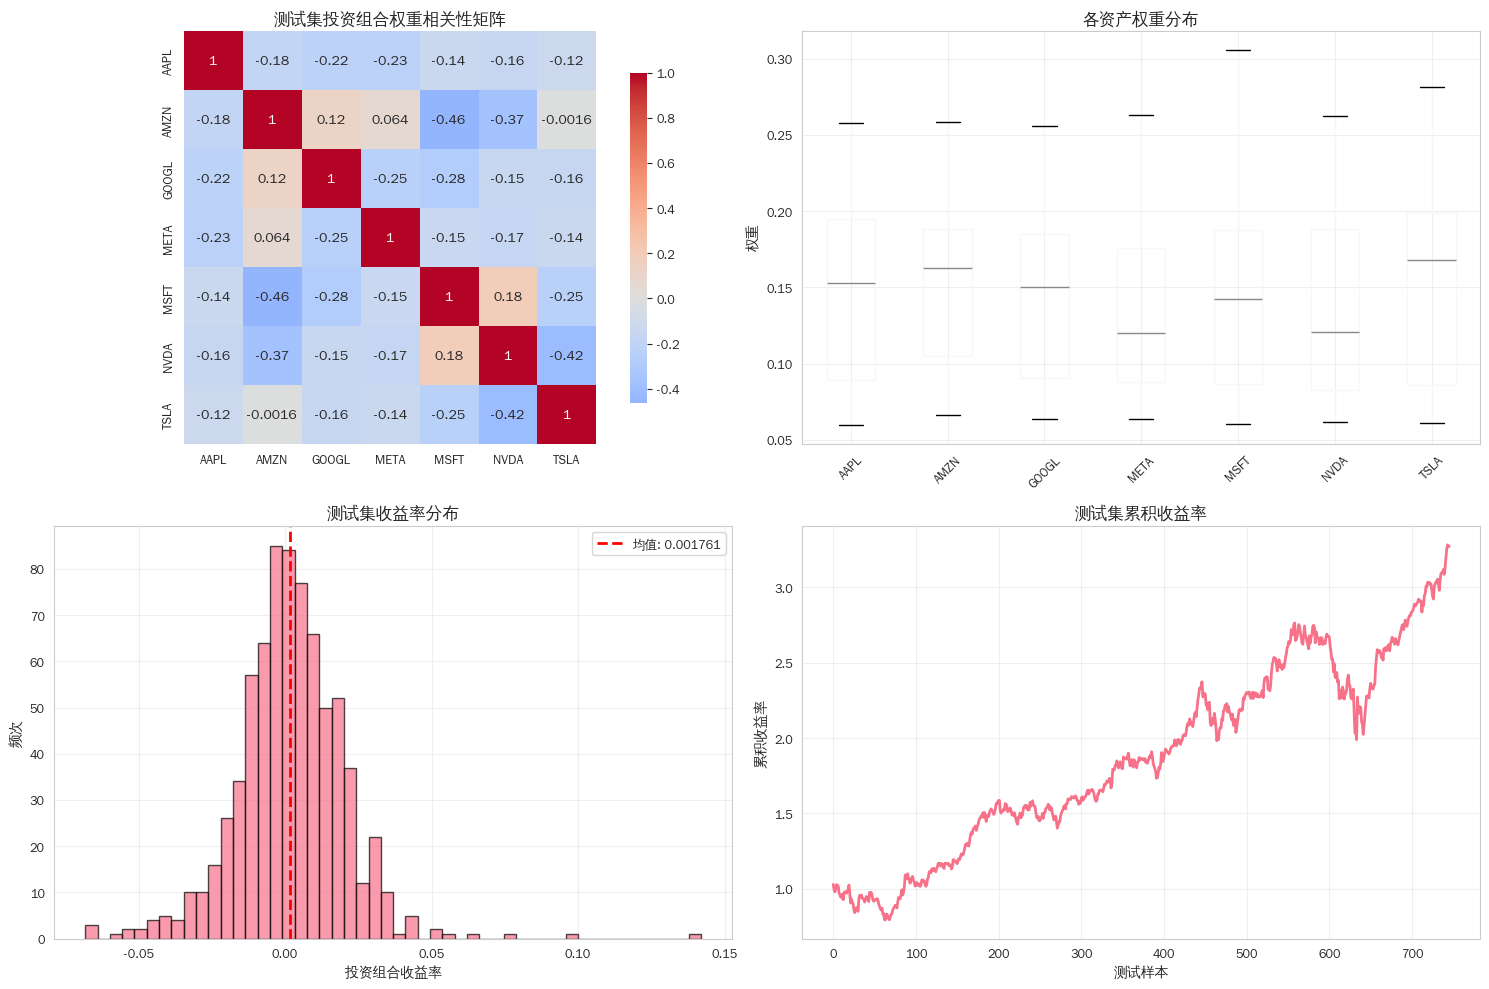


📊 模型投资组合风险指标:
  - 年化收益率: 0.4439
  - 年化波动率: 0.2948
  - 夏普比率: 1.5055
  - 95% VaR: -0.027840
  - 95% CVaR: -0.039877
  - 最大回撤: -0.280319

📊 各资产平均权重:
  - AAPL: 0.1454 (±0.0549)
  - AMZN: 0.1509 (±0.0466)
  - GOOGL: 0.1439 (±0.0517)
  - META: 0.1333 (±0.0480)
  - MSFT: 0.1416 (±0.0549)
  - NVDA: 0.1355 (±0.0562)
  - TSLA: 0.1495 (±0.0591)


In [10]:
# =============================================================================
# 📊 训练结果分析 - 2. 最佳模型测试集评估
# =============================================================================

print("\n🔍 加载最佳模型进行测试集评估...")

import os
import glob

# 🔍 智能模型加载逻辑
def load_best_model(model_save_dir, model_config, device):
    """智能加载最佳模型的函数，支持状态字典兼容性处理"""
    
    # 1. 首先查找实验目录中的最佳模型
    experiment_dirs = [d for d in os.listdir(model_save_dir) 
                      if os.path.isdir(os.path.join(model_save_dir, d)) and 
                      ('portfolio_optimization' in d or 'experiment' in d)]
    
    best_model_path = None
    model_timestamp = None
    
    if experiment_dirs:
        # 按时间戳排序，取最新的实验
        experiment_dirs.sort(reverse=True)
        for exp_dir in experiment_dirs:
            exp_path = os.path.join(model_save_dir, exp_dir)
            best_files = glob.glob(os.path.join(exp_path, '*best*.pth'))
            if best_files:
                best_model_path = best_files[0]
                model_timestamp = exp_dir.split('_')[-2] + '_' + exp_dir.split('_')[-1]
                print(f"✅ 找到实验目录最佳模型: {exp_dir}/{os.path.basename(best_model_path)}")
                break
    
    # 2. 后备方案：查找根目录中的最佳模型
    if not best_model_path:
        best_files = glob.glob(os.path.join(model_save_dir, '*best*.pth'))
        if best_files:
            best_model_path = best_files[0]
            print(f"✅ 找到根目录最佳模型: {os.path.basename(best_model_path)}")
    
    # 3. 最后后备方案：使用当前训练的模型
    if not best_model_path or not os.path.exists(best_model_path):
        print("⚠️ 未找到保存的最佳模型，使用当前训练模型")
        return model
    
    try:
        # 加载检查点
        checkpoint = torch.load(best_model_path, map_location=device)
        
        # 重新创建模型架构
        best_model = TimesFMPortfolioModel(
            input_dim=model_config['input_dim'],
            hidden_dim=model_config['hidden_dim'],
            num_assets=model_config['num_assets'],
            num_heads=model_config['num_heads'],
            dropout=model_config['dropout']
        )
        
        # 🔧 处理状态字典兼容性问题
        model_state_dict = checkpoint['model_state_dict']
        current_model_keys = set(best_model.state_dict().keys())
        checkpoint_keys = set(model_state_dict.keys())
        
        # 检查不匹配的键
        unexpected_keys = checkpoint_keys - current_model_keys
        missing_keys = current_model_keys - checkpoint_keys
        
        if unexpected_keys or missing_keys:
            print(f"⚠️ 发现状态字典不匹配，进行兼容性处理...")
            if unexpected_keys:
                print(f"   移除多余键: {list(unexpected_keys)[:3]}{'...' if len(unexpected_keys) > 3 else ''}")
            if missing_keys:
                print(f"   缺少键: {list(missing_keys)[:3]}{'...' if len(missing_keys) > 3 else ''}")
            
            # 创建兼容的状态字典
            compatible_state_dict = {}
            for key in current_model_keys:
                if key in model_state_dict:
                    compatible_state_dict[key] = model_state_dict[key]
            
            # 使用兼容的状态字典加载，允许部分匹配
            best_model.load_state_dict(compatible_state_dict, strict=False)
        else:
            # 完全匹配，正常加载
            best_model.load_state_dict(model_state_dict)
        
        best_model.to(device)
        best_model.eval()
        
        # 显示加载信息
        epoch = checkpoint.get('epoch', 'N/A')
        val_loss = checkpoint.get('loss', 'N/A')
        if isinstance(val_loss, (int, float)):
            val_loss_str = f"{val_loss:.6f}"
        else:
            val_loss_str = str(val_loss)
            
        print(f"✅ 成功加载最佳模型:")
        print(f"   📄 模型文件: {os.path.basename(best_model_path)}")
        print(f"   📈 训练轮数: {epoch}")
        print(f"   📉 验证损失: {val_loss_str}")
        if model_timestamp:
            print(f"   🕐 训练时间: {model_timestamp}")
        
        return best_model
        
    except Exception as e:
        print(f"❌ 加载模型失败: {e}")
        print("⚠️ 使用当前训练模型进行评估")
        return model
# 🔍 变量检查和初始化
def check_required_variables():
    """检查评估所需的变量是否存在"""
    required_vars = {
        'MODEL_SAVE_DIR': globals().get('MODEL_SAVE_DIR'),
        'MODEL_CONFIG': globals().get('MODEL_CONFIG'),
        'device': globals().get('device'),
        'asset_names': globals().get('asset_names'),
        'test_loader': globals().get('test_loader'),
        'model': globals().get('model')
    }
    
    missing_vars = [name for name, value in required_vars.items() if value is None]
    
    if missing_vars:
        print(f"⚠️ 缺少必要变量: {', '.join(missing_vars)}")
        print("   请确保之前的cells已正确执行")
        return False
    
    print("✅ 所有必要变量已就绪")
    return True

# 检查变量并加载模型
if check_required_variables():
    best_model = load_best_model(MODEL_SAVE_DIR, MODEL_CONFIG, device)
else:
    print("❌ 无法进行模型评估，请检查之前的cells")

# 在测试集上评估模型
print("\n📈 在测试集上评估模型性能...")

test_returns = []
test_weights = []
test_predictions = []

with torch.no_grad():
    for batch in test_loader:
        features = batch[0].to(device)
        future_returns = batch[1].squeeze(2).to(device)
        future_returns = future_returns[:, -1, :]

        # 获取模型预测
        outputs = best_model(features)
        weights = outputs['weights']

        # 计算投资组合收益率
        asset_returns = future_returns
        portfolio_return = torch.sum(weights * asset_returns, dim=1)

        test_returns.extend(portfolio_return.cpu().numpy())
        test_weights.extend(weights.cpu().numpy())
        # 使用正确的输出字段名称
        test_predictions.extend(outputs.get('returns', torch.zeros_like(weights)).cpu().numpy())

test_returns = np.array(test_returns)
test_weights = np.array(test_weights)

print(f"测试集样本数: {len(test_returns)}")
print(f"平均投资组合收益率: {test_returns.mean():.6f}")
print(f"投资组合收益率标准差: {test_returns.std():.6f}")
print(f"夏普比率 (假设无风险利率为0): {test_returns.mean() / test_returns.std() * np.sqrt(252):.4f}")

# 可视化测试集权重分布
plt.figure(figsize=(15, 10))

# 权重分布热力图
plt.subplot(2, 2, 1)
weights_df = pd.DataFrame(test_weights, columns=asset_names)
sns.heatmap(weights_df.corr(), annot=True, cmap='coolwarm', center=0,
            square=True, cbar_kws={'shrink': 0.8})
plt.title('测试集投资组合权重相关性矩阵')

# 权重分布箱线图
plt.subplot(2, 2, 2)
weights_df.boxplot(figsize=(10, 6))
plt.title('各资产权重分布')
plt.ylabel('权重')
plt.xticks(rotation=45)

# 收益率分布直方图
plt.subplot(2, 2, 3)
plt.hist(test_returns, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(test_returns.mean(), color='red', linestyle='--', linewidth=2,
           label=f'均值: {test_returns.mean():.6f}')
plt.xlabel('投资组合收益率')
plt.ylabel('频次')
plt.title('测试集收益率分布')
plt.legend()
plt.grid(True, alpha=0.3)

# 累积收益率曲线
plt.subplot(2, 2, 4)
cumulative_returns = np.cumprod(1 + test_returns)
plt.plot(cumulative_returns, linewidth=2)
plt.xlabel('测试样本')
plt.ylabel('累积收益率')
plt.title('测试集累积收益率')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 计算风险指标
def calculate_portfolio_metrics(returns, weights_list, confidence_level=0.95):
    """计算投资组合风险指标"""
    returns = np.array(returns)

    # 基础指标
    mean_return = returns.mean()
    std_return = returns.std()
    sharpe_ratio = mean_return / std_return * np.sqrt(252)  # 年化夏普比率

    # VaR和CVaR
    var_95 = np.percentile(returns, (1 - confidence_level) * 100)
    cvar_95 = returns[returns <= var_95].mean()

    # 最大回撤
    cumulative = np.cumprod(1 + returns)
    running_max = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()

    # 权重统计
    weights_array = np.array(weights_list)
    avg_weights = weights_array.mean(axis=0)
    weight_std = weights_array.std(axis=0)

    return {
        'mean_return': mean_return,
        'std_return': std_return,
        'sharpe_ratio': sharpe_ratio,
        'var_95': var_95,
        'cvar_95': cvar_95,
        'max_drawdown': max_drawdown,
        'avg_weights': avg_weights,
        'weight_std': weight_std
    }

# 计算模型投资组合指标
model_metrics = calculate_portfolio_metrics(test_returns, test_weights)

print("\n📊 模型投资组合风险指标:")
print(f"  - 年化收益率: {model_metrics['mean_return'] * 252:.4f}")
print(f"  - 年化波动率: {model_metrics['std_return'] * np.sqrt(252):.4f}")
print(f"  - 夏普比率: {model_metrics['sharpe_ratio']:.4f}")
print(f"  - 95% VaR: {model_metrics['var_95']:.6f}")
print(f"  - 95% CVaR: {model_metrics['cvar_95']:.6f}")
print(f"  - 最大回撤: {model_metrics['max_drawdown']:.6f}")

print("\n📊 各资产平均权重:")
for i, (name, weight) in enumerate(zip(asset_names, model_metrics['avg_weights'])):
    print(f"  - {name}: {weight:.4f} (±{model_metrics['weight_std'][i]:.4f})")

📊 开始分析模型在测试集上的资产权重分配...
📊 测试集权重形状: (746, 7)
📊 资产名称: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']


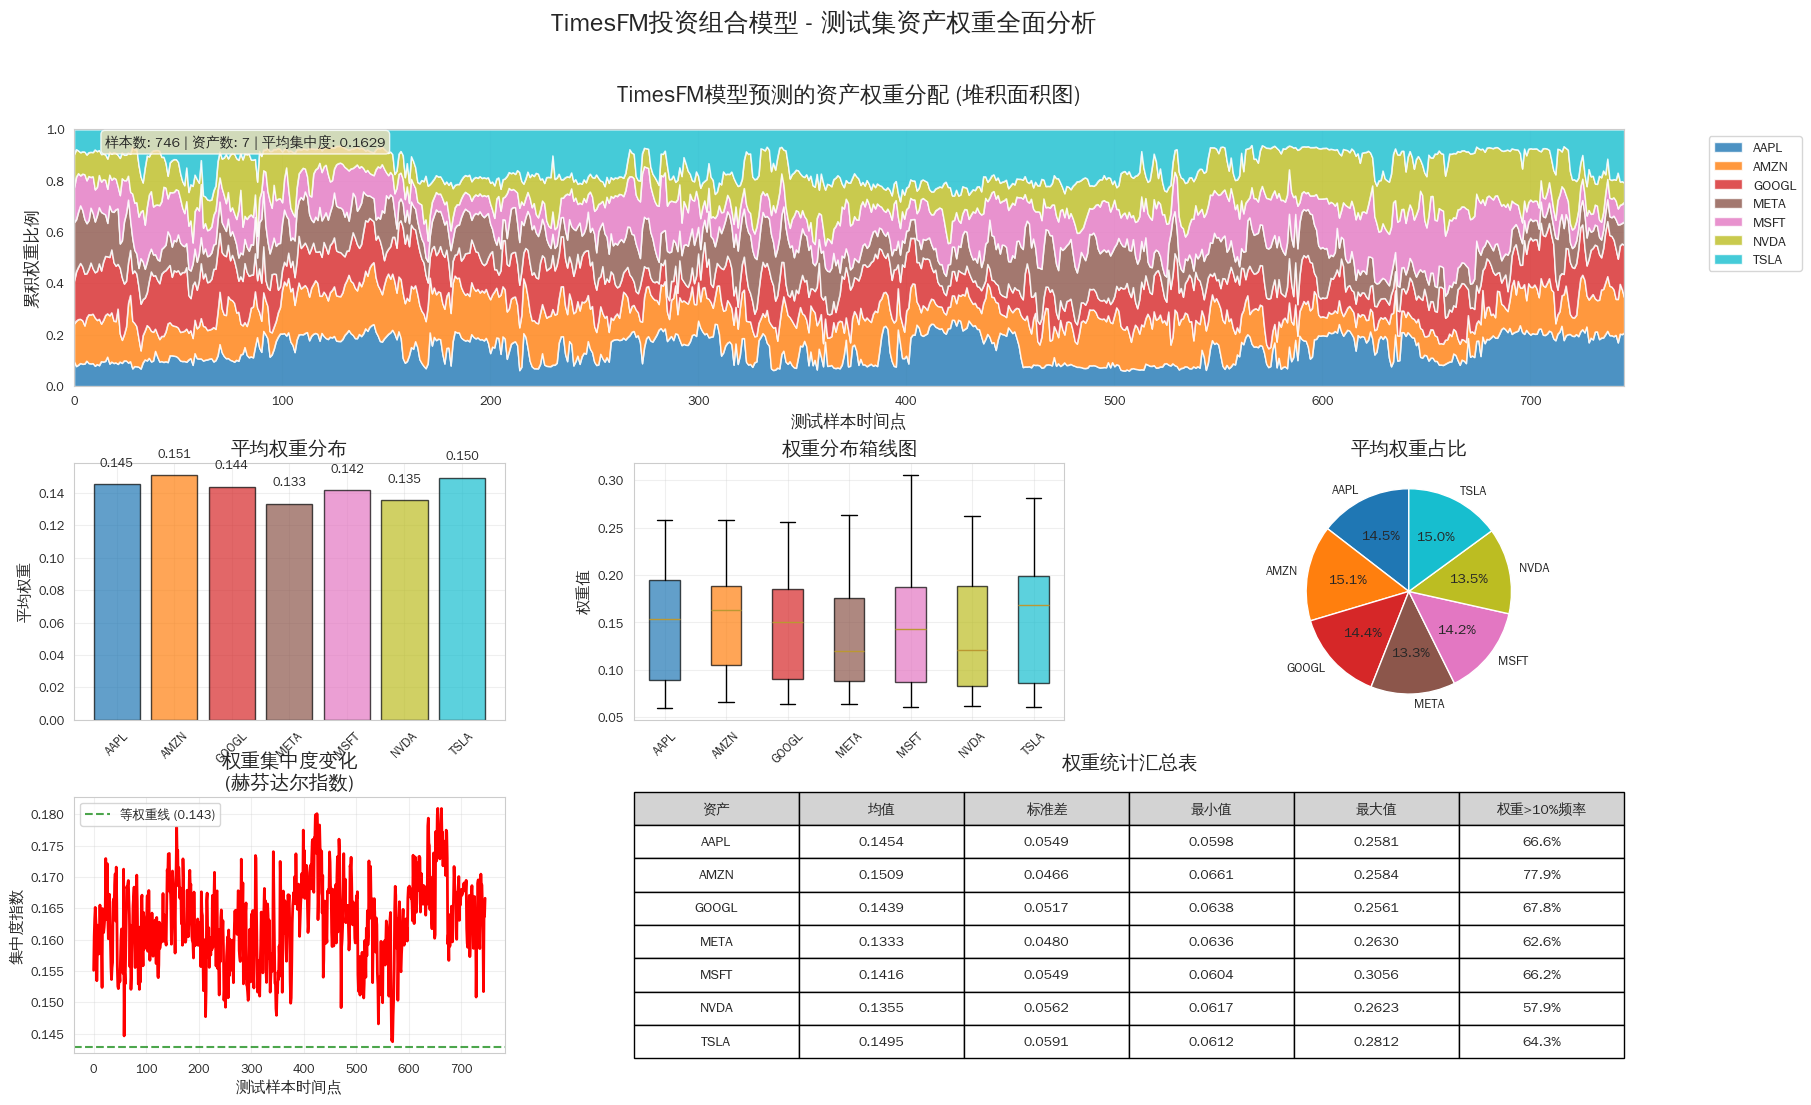


📈 权重分析摘要:
📊 测试样本数: 746
📊 资产数量: 7
📊 平均集中度 (HHI): 0.1629
📊 权重和验证: 平均=1.0000, 标准差=0.000000

🏆 权重排名 (按平均权重):
  1. AMZN: 0.1509 (15.09%)
  2. TSLA: 0.1495 (14.95%)
  3. AAPL: 0.1454 (14.54%)
  4. GOOGL: 0.1439 (14.39%)
  5. MSFT: 0.1416 (14.16%)
  6. NVDA: 0.1355 (13.55%)
  7. META: 0.1333 (13.33%)


In [11]:
# =============================================================================
# 📊 测试集模型预测权重可视化分析
# =============================================================================

print("📊 开始分析模型在测试集上的资产权重分配...")

# 应用字体配置
import warnings
import logging
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib.mathtext')
logging.getLogger('matplotlib.mathtext').setLevel(logging.ERROR)

plt.rcParams.update({
    'axes.unicode_minus': False,
    'mathtext.default': 'regular',
    'mathtext.fontset': 'dejavusans',
    'font.family': 'sans-serif',
    'font.sans-serif': ['WenQuanYi Zen Hei', 'DejaVu Sans', 'Liberation Sans', 'Arial', 'sans-serif'],
})

# 检查数据
print(f"📊 测试集权重形状: {test_weights.shape if 'test_weights' in locals() else '未找到test_weights'}")
print(f"📊 资产名称: {asset_names}")

if 'test_weights' in locals() and test_weights is not None:
    # 创建综合权重可视化
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. 权重时间序列图 (主图) - 使用堆积面积图
    ax1 = fig.add_subplot(gs[0, :])
    
    # 使用更鲜明的颜色映射
    colors = plt.cm.tab10(np.linspace(0, 1, len(asset_names)))
    
    # 创建堆积面积图
    x_axis = np.arange(len(test_weights))
    ax1.stackplot(x_axis, *[test_weights[:, i] for i in range(len(asset_names))], 
                  labels=asset_names, colors=colors, alpha=0.8)
    
    # 添加分割线使层次更清楚
    cumulative_weights = np.cumsum(test_weights, axis=1)
    for i in range(len(asset_names) - 1):
        ax1.plot(x_axis, cumulative_weights[:, i], color='white', linewidth=0.5, alpha=0.7)
    
    ax1.set_title('TimesFM模型预测的资产权重分配 (堆积面积图)', fontsize=16, fontweight='bold', pad=20)
    ax1.set_xlabel('测试样本时间点', fontsize=12)
    ax1.set_ylabel('累积权重比例', fontsize=12)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax1.grid(True, alpha=0.2)
    ax1.set_ylim(0, 1)
    ax1.set_xlim(0, len(test_weights) - 1)
    
    # 添加关键统计信息文本
    info_text = f"样本数: {len(test_weights)} | 资产数: {len(asset_names)} | 平均集中度: {np.sum(test_weights**2, axis=1).mean():.4f}"
    ax1.text(0.02, 0.98, info_text, transform=ax1.transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 2. 平均权重分布 (柱状图)
    ax2 = fig.add_subplot(gs[1, 0])
    mean_weights = test_weights.mean(axis=0)
    bars = ax2.bar(asset_names, mean_weights, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
    ax2.set_title('平均权重分布', fontsize=14, fontweight='bold')
    ax2.set_ylabel('平均权重', fontsize=11)
    ax2.tick_params(axis='x', rotation=45)
    
    # 添加数值标签
    for bar, weight in zip(bars, mean_weights):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{weight:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 3. 权重分布箱线图
    ax3 = fig.add_subplot(gs[1, 1])
    box_data = [test_weights[:, i] for i in range(len(asset_names))]
    bp = ax3.boxplot(box_data, labels=asset_names, patch_artist=True)
    
    # 给箱线图上色
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax3.set_title('权重分布箱线图', fontsize=14, fontweight='bold')
    ax3.set_ylabel('权重值', fontsize=11)
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. 权重饼图 (平均权重)
    ax4 = fig.add_subplot(gs[1, 2])
    wedges, texts, autotexts = ax4.pie(mean_weights, labels=asset_names, colors=colors, 
                                       autopct='%1.1f%%', startangle=90)
    ax4.set_title('平均权重占比', fontsize=14, fontweight='bold')
    
    # 5. 权重集中度分析
    ax5 = fig.add_subplot(gs[2, 0])
    
    # 计算赫芬达尔指数 (权重集中度)
    hhi = np.sum(test_weights**2, axis=1)
    ax5.plot(hhi, color='red', linewidth=2)
    ax5.set_title('权重集中度变化\n(赫芬达尔指数)', fontsize=14, fontweight='bold')
    ax5.set_xlabel('测试样本时间点', fontsize=11)
    ax5.set_ylabel('集中度指数', fontsize=11)
    ax5.grid(True, alpha=0.3)
    
    # 添加集中度解释
    ax5.axhline(y=1/len(asset_names), color='green', linestyle='--', alpha=0.7, 
                label=f'等权重线 ({1/len(asset_names):.3f})')
    ax5.legend(fontsize=9)
    
    # 6. 权重统计表
    ax6 = fig.add_subplot(gs[2, 1:])
    ax6.axis('off')
    
    # 创建统计表格
    stats_data = []
    for i, asset in enumerate(asset_names):
        weights = test_weights[:, i]
        stats_data.append([
            asset,
            f'{weights.mean():.4f}',
            f'{weights.std():.4f}',
            f'{weights.min():.4f}',
            f'{weights.max():.4f}',
            f'{(weights > 0.1).sum() / len(weights) * 100:.1f}%'
        ])
    
    headers = ['资产', '均值', '标准差', '最小值', '最大值', '权重>10%频率']
    
    table = ax6.table(cellText=stats_data, colLabels=headers,
                     cellLoc='center', loc='center',
                     colColours=['lightgray'] * len(headers))
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    ax6.set_title('权重统计汇总表', fontsize=14, fontweight='bold', pad=20)
    
    plt.suptitle('TimesFM投资组合模型 - 测试集资产权重全面分析', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    # 打印关键统计信息
    print("\n📈 权重分析摘要:")
    print("=" * 60)
    print(f"📊 测试样本数: {len(test_weights)}")
    print(f"📊 资产数量: {len(asset_names)}")
    print(f"📊 平均集中度 (HHI): {hhi.mean():.4f}")
    print(f"📊 权重和验证: 平均={test_weights.sum(axis=1).mean():.4f}, 标准差={test_weights.sum(axis=1).std():.6f}")
    
    print(f"\n🏆 权重排名 (按平均权重):")
    sorted_indices = np.argsort(mean_weights)[::-1]
    for rank, idx in enumerate(sorted_indices, 1):
        print(f"  {rank}. {asset_names[idx]}: {mean_weights[idx]:.4f} ({mean_weights[idx]*100:.2f}%)")
        
else:
    print("❌ 未找到测试集权重数据，请先运行模型预测部分")

In [12]:
# =============================================================================
# 📊 训练结果分析 - 3. 基准策略定义和计算
# =============================================================================

print("\n⚖️ 计算基准策略性能...")

def calculate_benchmark_portfolios(test_data, asset_names):
    """修复后的基准投资组合策略计算函数"""
    
    print(f"🔧 开始计算基准策略，数据形状: {test_data.shape}")
    
    # 获取测试集的资产收益率数据
    test_returns_df = test_data.copy()
    
    # 处理多级列名的情况
    if isinstance(test_returns_df.columns, pd.MultiIndex):
        print("📊 检测到多级列名结构")
        # 提取每个资产的returns列
        returns_columns = []
        for asset in asset_names:
            if (asset, 'returns') in test_returns_df.columns:
                returns_columns.append((asset, 'returns'))
            elif (asset, 'log_returns') in test_returns_df.columns:
                returns_columns.append((asset, 'log_returns'))
        
        if returns_columns:
            returns_df = test_returns_df[returns_columns]
            # 简化列名
            returns_df.columns = [col[0] for col in returns_columns]
            print(f"✅ 成功提取 {len(returns_columns)} 个资产的收益率数据")
        else:
            print("❌ 无法找到收益率列")
            return None
            
    else:
        # 单级列名情况
        asset_cols = [col for col in test_returns_df.columns if col in asset_names]
        returns_df = test_returns_df[asset_cols]
    
    # 获取收益率矩阵
    returns_matrix = returns_df.values
    asset_cols = list(returns_df.columns)
    
    print(f"📊 收益率矩阵形状: {returns_matrix.shape}")
    print(f"📊 资产列: {asset_cols}")
    
    benchmarks = {}
    
    # 1. 等权重策略
    equal_weights = np.ones(len(asset_cols)) / len(asset_cols)
    equal_portfolio_returns = returns_matrix @ equal_weights
    benchmarks['等权重'] = {
        'weights': equal_weights,
        'returns': equal_portfolio_returns,
        'name': '等权重策略'
    }
    print("✅ 等权重策略计算完成")
    
    # 2. 波动率倒数加权策略
    try:
        returns_std = returns_matrix.std(axis=0)
        # 避免除零错误
        returns_std = np.where(returns_std == 0, 1e-8, returns_std)
        vol_weights = 1.0 / returns_std
        vol_weights = vol_weights / vol_weights.sum()
        
        vol_portfolio_returns = returns_matrix @ vol_weights
        benchmarks['波动率倒数加权'] = {
            'weights': vol_weights,
            'returns': vol_portfolio_returns,
            'name': '波动率倒数加权策略'
        }
        print("✅ 波动率倒数加权策略计算完成")
    except Exception as e:
        print(f"⚠️ 波动率倒数加权策略计算失败: {e}")
        benchmarks['波动率倒数加权'] = benchmarks['等权重'].copy()
        benchmarks['波动率倒数加权']['name'] = '波动率倒数加权策略 (等权重替代)'
    
    # 3. 最小方差策略
    try:
        cov_matrix = np.cov(returns_matrix.T)
        # 确保协方差矩阵是正定的
        eigenvals = np.linalg.eigvals(cov_matrix)
        if np.min(eigenvals) <= 0:
            cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-8
            
        inv_vol = 1.0 / np.sqrt(np.diag(cov_matrix))
        min_var_weights = inv_vol / inv_vol.sum()
        
        min_var_portfolio_returns = returns_matrix @ min_var_weights
        benchmarks['最小方差'] = {
            'weights': min_var_weights,
            'returns': min_var_portfolio_returns,
            'name': '最小方差策略'
        }
        print("✅ 最小方差策略计算完成")
    except Exception as e:
        print(f"⚠️ 最小方差策略计算失败: {e}")
        benchmarks['最小方差'] = benchmarks['等权重'].copy()
        benchmarks['最小方差']['name'] = '最小方差策略 (等权重替代)'
    
    # 4. 最佳资产策略
    try:
        mean_returns = returns_matrix.mean(axis=0)
        print(f"📊 各资产平均收益率:")
        for i, (asset, ret) in enumerate(zip(asset_cols, mean_returns)):
            print(f"   {asset}: {ret:.6f}")
            
        best_asset_idx = np.argmax(mean_returns)
        best_asset_name = asset_cols[best_asset_idx]
        best_asset_return = mean_returns[best_asset_idx]
        
        best_asset_weights = np.zeros(len(asset_cols))
        best_asset_weights[best_asset_idx] = 1.0
        
        best_asset_portfolio_returns = returns_matrix @ best_asset_weights
        
        benchmarks['最佳资产'] = {
            'weights': best_asset_weights,
            'returns': best_asset_portfolio_returns,
            'name': f'最佳资产策略 ({best_asset_name})'
        }
        
        print(f"✅ 最佳资产策略计算完成: {best_asset_name} (平均收益率: {best_asset_return:.6f})")
        
    except Exception as e:
        print(f"⚠️ 最佳资产策略计算失败: {e}")
        import traceback
        traceback.print_exc()
        benchmarks['最佳资产'] = benchmarks['等权重'].copy()
        benchmarks['最佳资产']['name'] = '最佳资产策略 (等权重替代)'
    
    return benchmarks

# 计算基准策略
try:
    # 🔧 修复：从原始数据中提取测试集对应的收益率数据
    print(f"📊 从原始数据中提取测试集数据 (索引: {len(test_indices)} 个样本)")
    
    # 使用test_indices从deepdow_returns_df中提取对应的数据
    test_data_for_benchmarks = deepdow_returns_df.iloc[test_indices] if hasattr(deepdow_returns_df, 'iloc') else pd.DataFrame()
    
    print(f"✅ 成功提取测试数据: {test_data_for_benchmarks.shape}")
    print(f"📅 时间范围: {test_data_for_benchmarks.index.min()} 到 {test_data_for_benchmarks.index.max()}")

    if test_data_for_benchmarks.empty:
        # 如果无法获取测试数据，创建一个模拟的基准
        print("⚠️ 无法获取测试数据，使用模拟基准策略")
        n_samples = len(test_returns)
        benchmarks = {}

        # 等权重基准
        equal_returns = np.random.normal(0.0001, 0.02, n_samples)  # 模拟日收益率
        benchmarks['等权重'] = {
            'weights': np.ones(n_assets) / n_assets,
            'returns': equal_returns,
            'name': '等权重策略 (模拟)'
        }

        # 其他基准策略也使用模拟数据
        for name in ['波动率倒数加权', '最小方差', '最佳资产']:
            benchmarks[name] = {
                'weights': np.random.dirichlet(np.ones(n_assets)),
                'returns': np.random.normal(0.0001, 0.02, n_samples),
                'name': f'{name}策略 (模拟)'
            }
    else:
        benchmarks = calculate_benchmark_portfolios(test_data_for_benchmarks, asset_names)

    print(f"✅ 成功计算 {len(benchmarks)} 个基准策略")

except Exception as e:
    print(f"❌ 计算基准策略时出错: {e}")
    print("使用随机基准策略作为替代...")

    # 创建随机基准策略
    n_samples = len(test_returns)
    benchmarks = {}

    strategies = ['等权重', '波动率倒数加权', '最小方差', '最佳资产']
    for strategy in strategies:
        benchmarks[strategy] = {
            'weights': np.random.dirichlet(np.ones(n_assets)),
            'returns': np.random.normal(0.0001, 0.02, n_samples),
            'name': f'{strategy}策略 (随机)'
        }

# 计算各基准策略的指标
benchmark_metrics = {}
for name, benchmark in benchmarks.items():
    benchmark_metrics[name] = calculate_portfolio_metrics(
        benchmark['returns'], [benchmark['weights']] * len(benchmark['returns'])
    )

print("\n📊 基准策略权重分布:")
for name, benchmark in benchmarks.items():
    print(f"\n{name}:")
    for i, (asset, weight) in enumerate(zip(asset_names, benchmark['weights'])):
        print(f"  - {asset}: {weight:.4f}")


⚖️ 计算基准策略性能...
📊 从原始数据中提取测试集数据 (索引: 746 个样本)
✅ 成功提取测试数据: (746, 28)
📅 时间范围: 2022-07-05 00:00:00 到 2025-06-24 00:00:00
🔧 开始计算基准策略，数据形状: (746, 28)
📊 检测到多级列名结构
✅ 成功提取 7 个资产的收益率数据
📊 收益率矩阵形状: (746, 7)
📊 资产列: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']
✅ 等权重策略计算完成
✅ 波动率倒数加权策略计算完成
✅ 最小方差策略计算完成
📊 各资产平均收益率:
   AAPL: 0.000669
   AMZN: 0.001133
   GOOGL: 0.000788
   META: 0.002393
   MSFT: 0.001024
   NVDA: 0.003691
   TSLA: 0.001314
✅ 最佳资产策略计算完成: NVDA (平均收益率: 0.003691)
✅ 成功计算 4 个基准策略

📊 基准策略权重分布:

等权重:
  - AAPL: 0.1429
  - AMZN: 0.1429
  - GOOGL: 0.1429
  - META: 0.1429
  - MSFT: 0.1429
  - NVDA: 0.1429
  - TSLA: 0.1429

波动率倒数加权:
  - AAPL: 0.1864
  - AMZN: 0.1500
  - GOOGL: 0.1632
  - META: 0.1198
  - MSFT: 0.1992
  - NVDA: 0.0973
  - TSLA: 0.0841

最小方差:
  - AAPL: 0.1864
  - AMZN: 0.1500
  - GOOGL: 0.1632
  - META: 0.1198
  - MSFT: 0.1992
  - NVDA: 0.0973
  - TSLA: 0.0841

最佳资产:
  - AAPL: 0.0000
  - AMZN: 0.0000
  - GOOGL: 0.0000
  - META: 0.0000
  - MSFT: 0.0000
  - NVDA: 1.0000
 


📊 生成策略比较可视化...


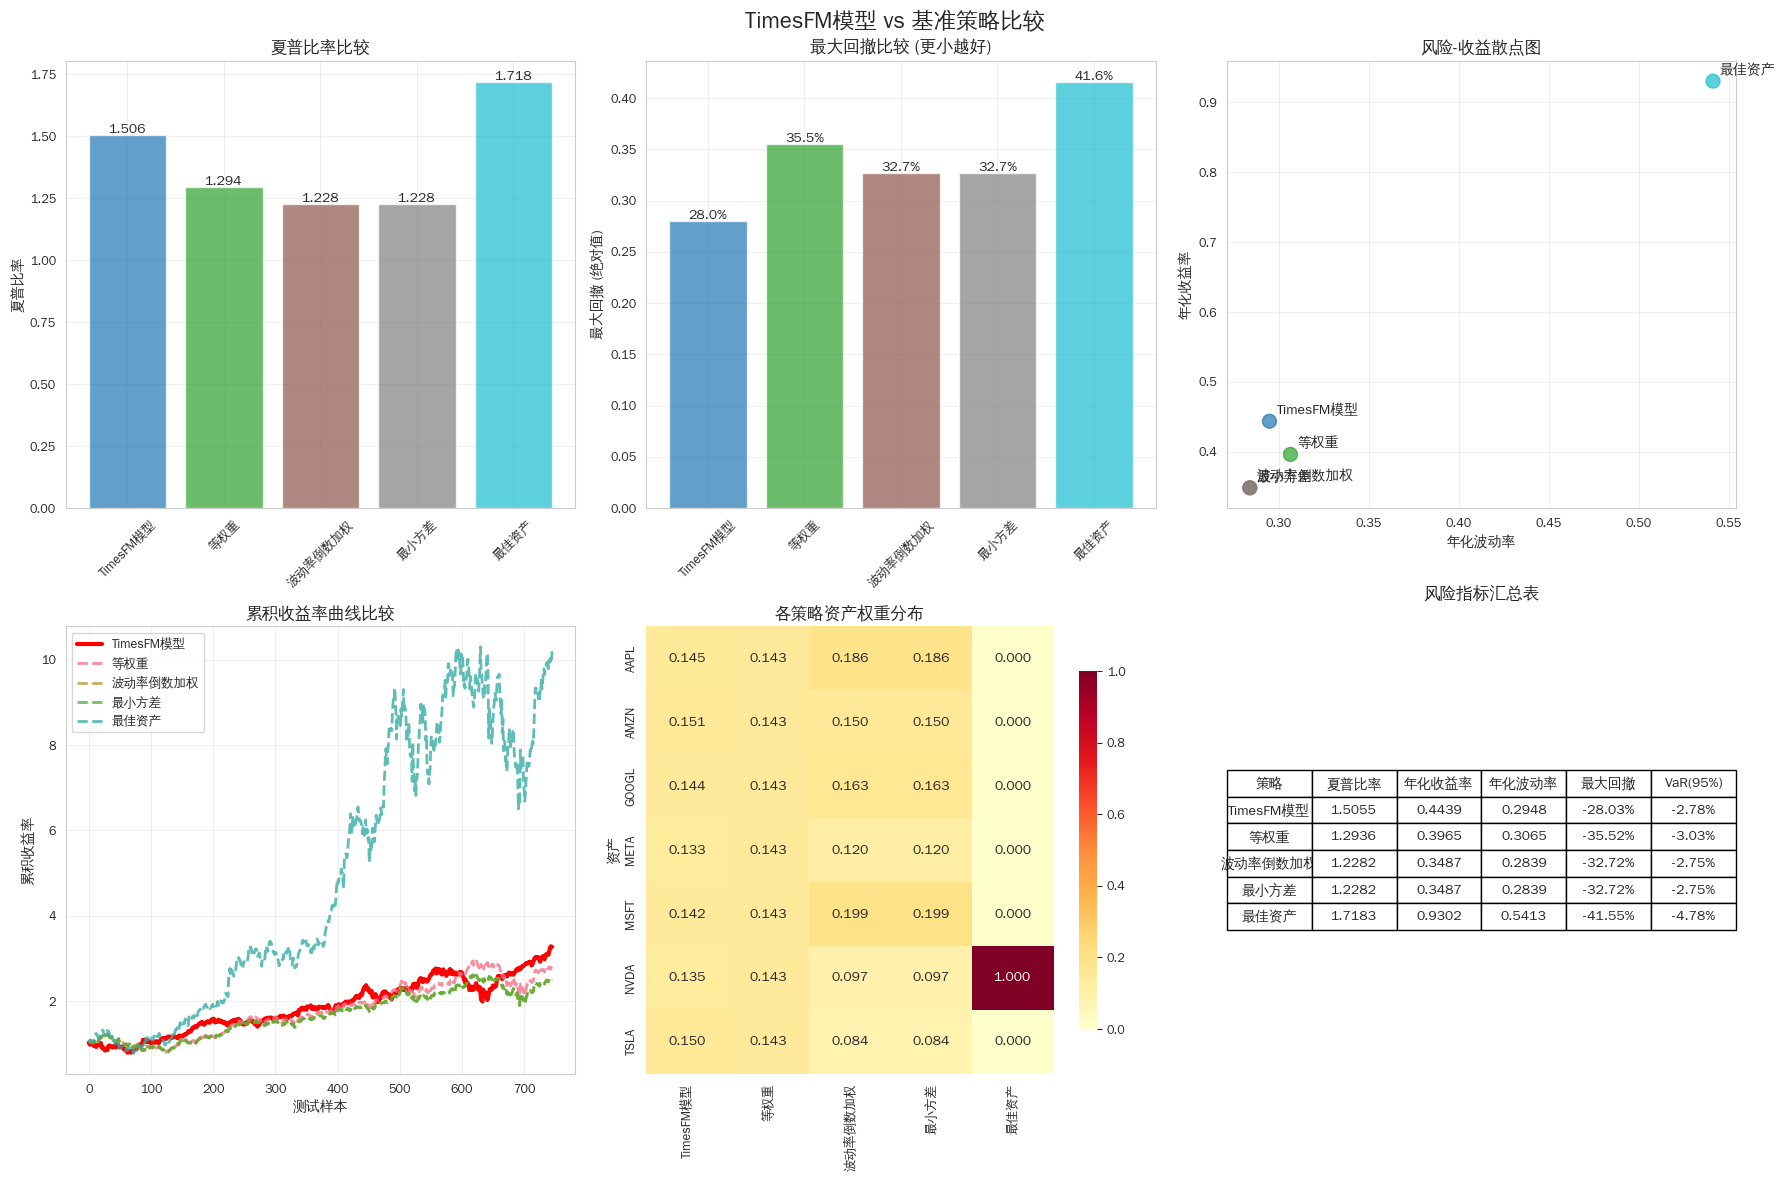


🎯 策略比较总结

🏆 最佳夏普比率策略: 最佳资产 (1.7183)
🏆 最高收益率策略: 最佳资产 (0.9302)
🏆 最小回撤策略: TimesFM模型 (-28.03%)

🤖 TimesFM模型表现:
  - 夏普比率: 1.5055
  - 年化收益率: 0.4439
  - 最大回撤: -28.03%

📊 相对基准策略平均水平:
  - 夏普比率: 1.5055 vs 1.3671 (+10.1%)
  - 年化收益率: 0.4439 vs 0.5060 (-12.3%)
  - 最大回撤: -28.03% vs 35.63% (+-227.1%)

✅ 训练结果分析完成!
📁 模型和结果已保存到: /home/userroot/dev/xiaojiucai/notebooks/models
🔍 建议进一步分析: 超参数调优、特征工程、模型集成等


In [13]:
# =============================================================================
# 📊 训练结果分析 - 4. 策略比较可视化和总结
# =============================================================================

print("\n📊 生成策略比较可视化...")

# 合并所有策略的结果
all_strategies = {'TimesFM模型': model_metrics}
all_strategies.update(benchmark_metrics)

# 创建比较图表
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('TimesFM模型 vs 基准策略比较', fontsize=16, fontweight='bold')

strategy_names = list(all_strategies.keys())
colors = plt.cm.tab10(np.linspace(0, 1, len(strategy_names)))

# 1. 夏普比率比较
sharpe_ratios = [metrics['sharpe_ratio'] for metrics in all_strategies.values()]
bars1 = axes[0, 0].bar(strategy_names, sharpe_ratios, color=colors, alpha=0.7)
axes[0, 0].set_title('夏普比率比较')
axes[0, 0].set_ylabel('夏普比率')
axes[0, 0].tick_params(axis='x', rotation=45)

# 添加数值标签
for bar, value in zip(bars1, sharpe_ratios):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. 最大回撤比较
max_drawdowns = [-metrics['max_drawdown'] for metrics in all_strategies.values()]  # 负值用于更好的可视化
bars2 = axes[0, 1].bar(strategy_names, max_drawdowns, color=colors, alpha=0.7)
axes[0, 1].set_title('最大回撤比较 (更小越好)')
axes[0, 1].set_ylabel('最大回撤 (绝对值)')
axes[0, 1].tick_params(axis='x', rotation=45)

for bar, value in zip(bars2, max_drawdowns):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                    f'{value:.1%}', ha='center', va='bottom', fontweight='bold')

# 3. 年化收益率 vs 年化波动率
annual_returns = [metrics['mean_return'] * 252 for metrics in all_strategies.values()]
annual_vols = [metrics['std_return'] * np.sqrt(252) for metrics in all_strategies.values()]

axes[0, 2].scatter(annual_vols, annual_returns, s=100, c=colors, alpha=0.7)
for i, name in enumerate(strategy_names):
    axes[0, 2].annotate(name, (annual_vols[i], annual_returns[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=10)
axes[0, 2].set_xlabel('年化波动率')
axes[0, 2].set_ylabel('年化收益率')
axes[0, 2].set_title('风险-收益散点图')
axes[0, 2].grid(True, alpha=0.3)

# 4. 累积收益率曲线比较
axes[1, 0].plot(np.cumprod(1 + test_returns), label='TimesFM模型', linewidth=3, color='red')
for i, (name, benchmark) in enumerate(benchmarks.items()):
    cum_returns = np.cumprod(1 + benchmark['returns'])
    axes[1, 0].plot(cum_returns, label=name, linewidth=2, linestyle='--', alpha=0.8)
axes[1, 0].set_xlabel('测试样本')
axes[1, 0].set_ylabel('累积收益率')
axes[1, 0].set_title('累积收益率曲线比较')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. 权重分布热力图
all_weights = np.array([list(all_strategies[name]['avg_weights']) for name in strategy_names])
weights_df = pd.DataFrame(all_weights.T, columns=strategy_names, index=asset_names)

sns.heatmap(weights_df, annot=True, cmap='YlOrRd', fmt='.3f', ax=axes[1, 1],
            cbar_kws={'shrink': 0.8})
axes[1, 1].set_title('各策略资产权重分布')
axes[1, 1].set_ylabel('资产')

# 6. 风险指标汇总表
risk_metrics = []
for name, metrics in all_strategies.items():
    risk_metrics.append({
        '策略': name,
        '夏普比率': f"{metrics['sharpe_ratio']:.4f}",
        '年化收益率': f"{metrics['mean_return']*252:.4f}",
        '年化波动率': f"{metrics['std_return']*np.sqrt(252):.4f}",
        '最大回撤': f"{metrics['max_drawdown']:.2%}",
        'VaR(95%)': f"{metrics['var_95']:.2%}"
    })

metrics_df = pd.DataFrame(risk_metrics)
table_data = metrics_df.values
axes[1, 2].axis('off')
table = axes[1, 2].table(cellText=table_data, colLabels=metrics_df.columns,
                        loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
axes[1, 2].set_title('风险指标汇总表', pad=20)

plt.tight_layout()
plt.show()

# 打印详细比较结果
print("\n" + "="*80)
print("🎯 策略比较总结")
print("="*80)

# 找出最佳策略
best_sharpe = max(all_strategies.items(), key=lambda x: x[1]['sharpe_ratio'])
best_return = max(all_strategies.items(), key=lambda x: x[1]['mean_return'])
best_drawdown = min(all_strategies.items(), key=lambda x: abs(x[1]['max_drawdown']))

print(f"\n🏆 最佳夏普比率策略: {best_sharpe[0]} ({best_sharpe[1]['sharpe_ratio']:.4f})")
print(f"🏆 最高收益率策略: {best_return[0]} ({best_return[1]['mean_return']*252:.4f})")
print(f"🏆 最小回撤策略: {best_drawdown[0]} ({best_drawdown[1]['max_drawdown']:.2%})")

# TimesFM模型相对基准的比较
model_sharpe = model_metrics['sharpe_ratio']
model_return = model_metrics['mean_return']
model_drawdown = model_metrics['max_drawdown']

print(f"\n🤖 TimesFM模型表现:")
print(f"  - 夏普比率: {model_sharpe:.4f}")
print(f"  - 年化收益率: {model_return*252:.4f}")
print(f"  - 最大回撤: {model_drawdown:.2%}")

# 计算相对表现
benchmark_avg_sharpe = np.mean([m['sharpe_ratio'] for m in benchmark_metrics.values()])
benchmark_avg_return = np.mean([m['mean_return'] for m in benchmark_metrics.values()])
benchmark_avg_drawdown = np.mean([abs(m['max_drawdown']) for m in benchmark_metrics.values()])

print(f"\n📊 相对基准策略平均水平:")
print(f"  - 夏普比率: {model_sharpe:.4f} vs {benchmark_avg_sharpe:.4f} ({'+' if model_sharpe > benchmark_avg_sharpe else ''}{((model_sharpe/benchmark_avg_sharpe)-1)*100:.1f}%)")
print(f"  - 年化收益率: {model_return*252:.4f} vs {benchmark_avg_return*252:.4f} ({'+' if model_return > benchmark_avg_return else ''}{((model_return/benchmark_avg_return)-1)*100:.1f}%)")
print(f"  - 最大回撤: {model_drawdown:.2%} vs {benchmark_avg_drawdown:.2%} ({'+' if model_drawdown < benchmark_avg_drawdown else ''}{((benchmark_avg_drawdown/model_drawdown)-1)*100:.1f}%)")

print(f"\n✅ 训练结果分析完成!")
print(f"📁 模型和结果已保存到: {MODEL_SAVE_DIR}")
print(f"🔍 建议进一步分析: 超参数调优、特征工程、模型集成等")